In [357]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from datetime import timedelta
from scipy.stats import norm
from scipy import stats
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [235]:
df = pd.read_csv("df1.csv", index_col="date")
df = df.drop('ticker', axis=1)
df.index = pd.to_datetime(df.index)
df.head()

open       high        low      close   adjclose    volume
date                                                                  
1970-03-25   0.0  91.070000  88.110001  89.769997  89.769997  17500000
1970-03-26   0.0  90.650002  89.180000  89.919998  89.919998  11350000
1970-03-30   0.0  90.410004  88.910004  89.629997  89.629997   9600000
1970-03-31   0.0  90.169998  88.849998  89.629997  89.629997   8370000
1970-04-01   0.0  90.620003  89.300003  90.070000  90.070000   9810000

In [236]:
df.describe()


open          high           low         close      adjclose  \
count  13521.000000  13521.000000  13521.000000  13521.000000  13521.000000   
mean    1021.179083   1050.359598   1037.401141   1044.286985   1044.286985   
std     1114.446044   1100.194674   1087.504862   1094.203967   1094.203967   
min        0.000000     63.230000     60.959999     62.279999     62.279999   
25%      156.860001    158.050003    156.410004    157.059998    157.059998   
50%      742.750000    747.650024    737.010010    743.330017    743.330017   
75%     1389.939941   1399.209961   1378.699951   1390.329956   1390.329956   
max     4804.509766   4818.620117   4780.040039   4796.560059   4796.560059   

             volume  
count  1.352100e+04  
mean   1.569559e+09  
std    1.866762e+09  
min    0.000000e+00  
25%    8.024000e+07  
50%    4.636000e+08  
75%    3.261190e+09  
max    1.145623e+10

# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

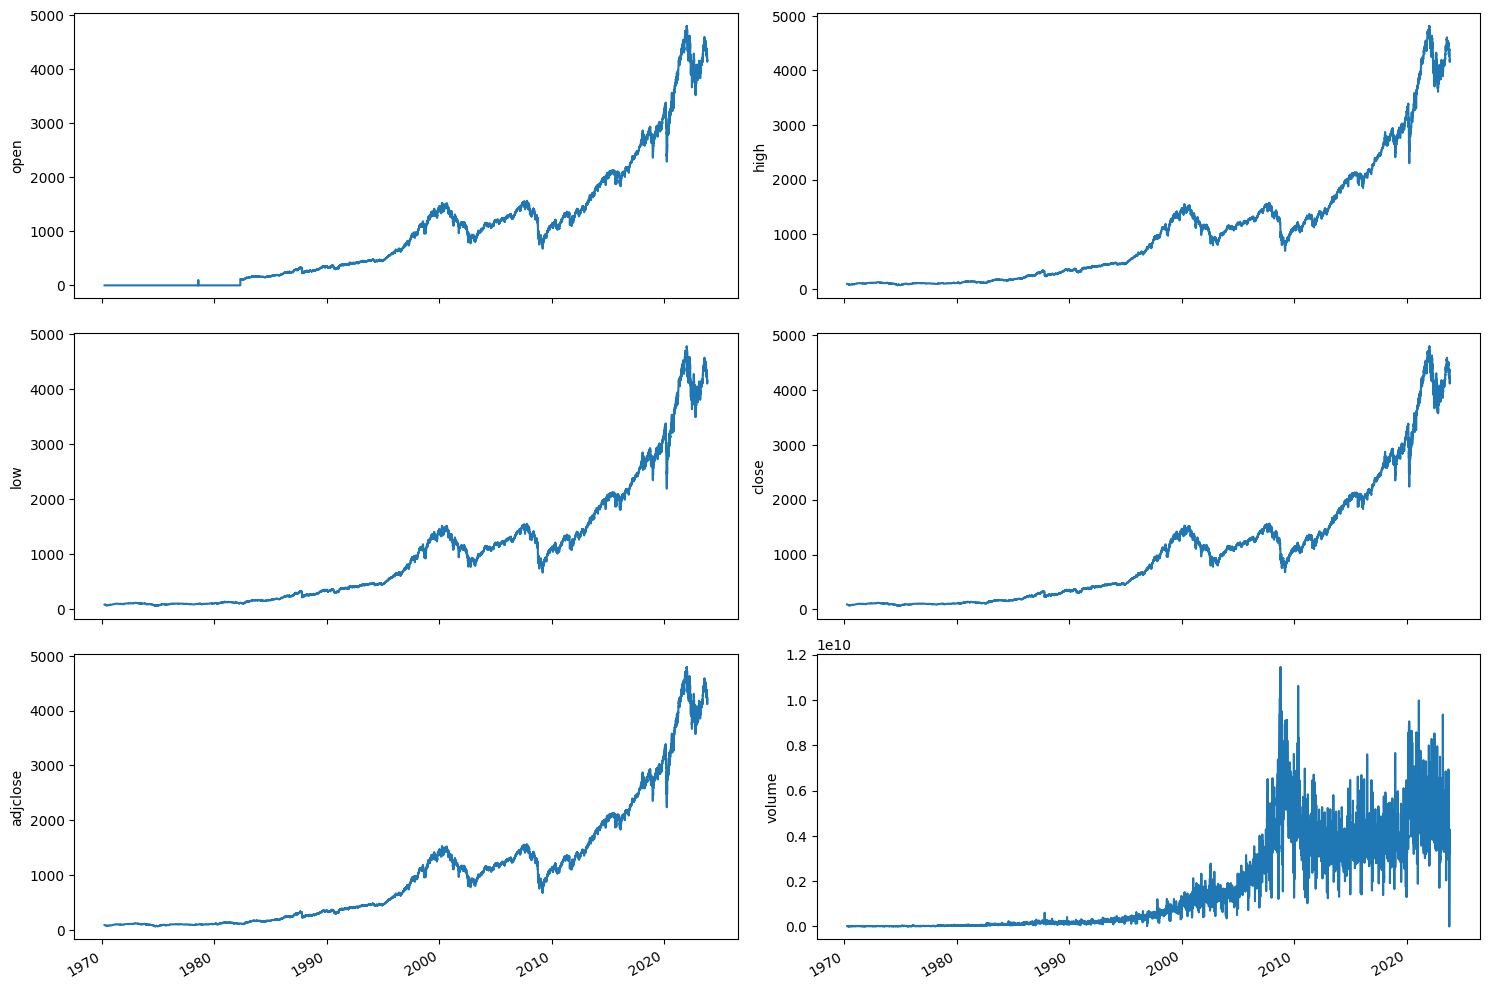

In [237]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

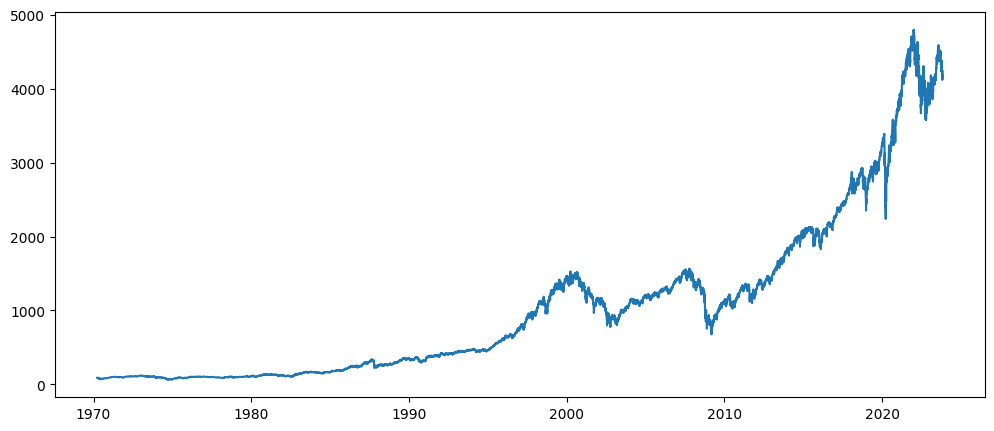

In [238]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [239]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

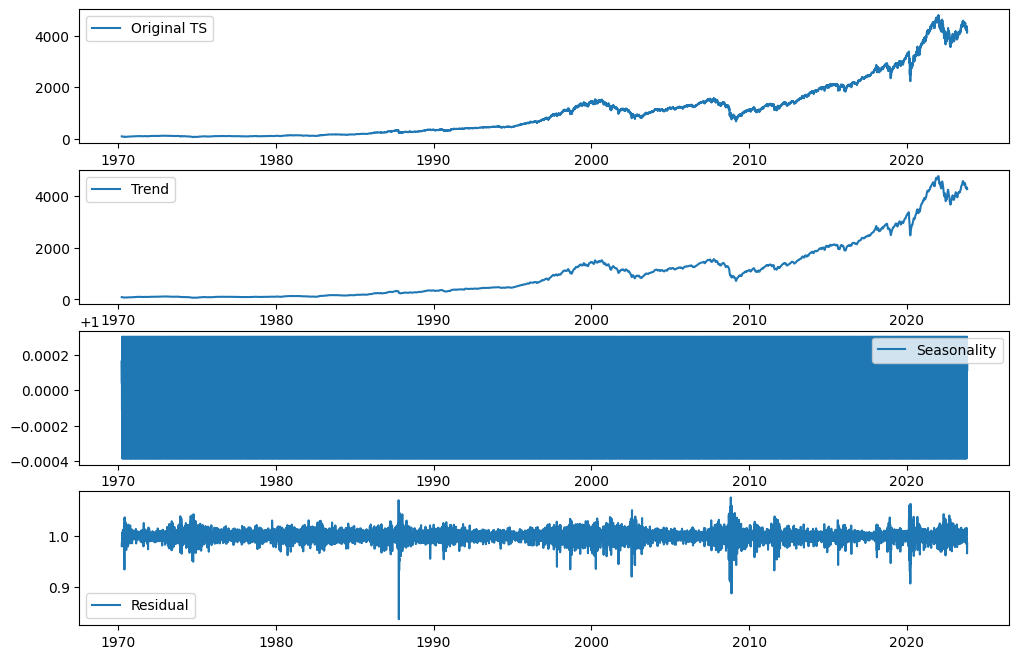

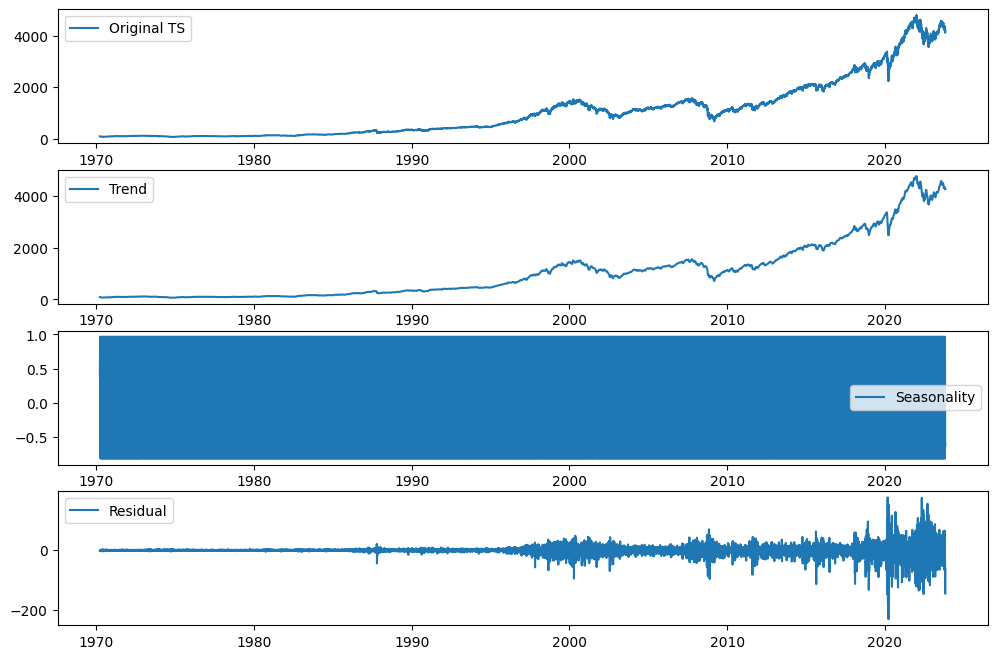

In [240]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

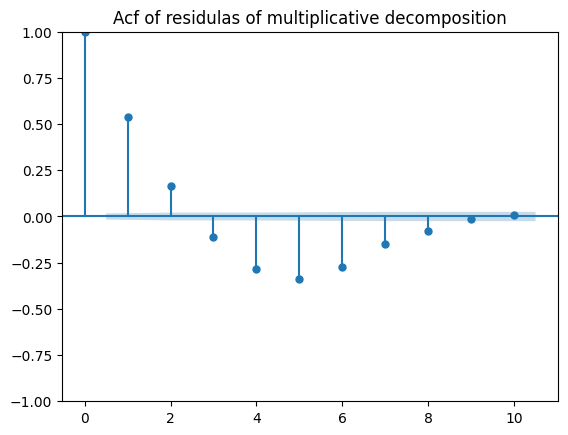

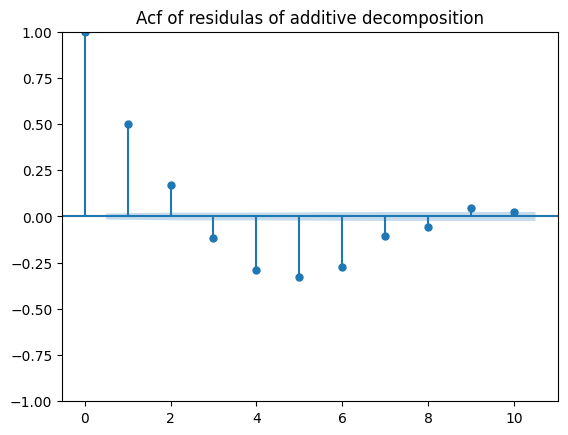

In [241]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

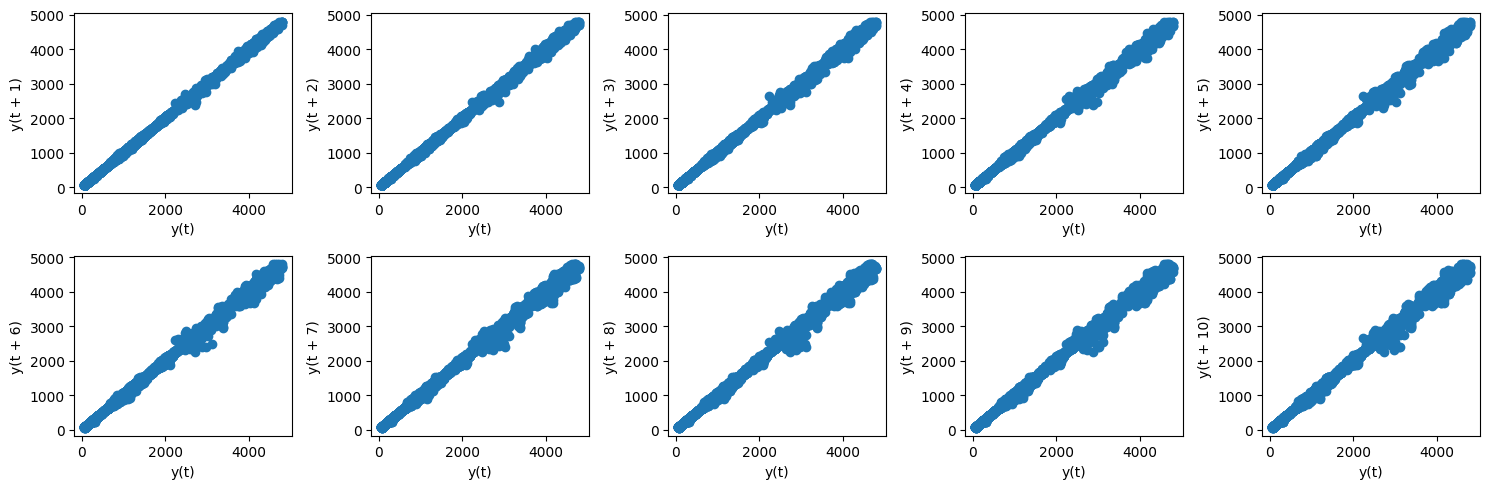

In [242]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

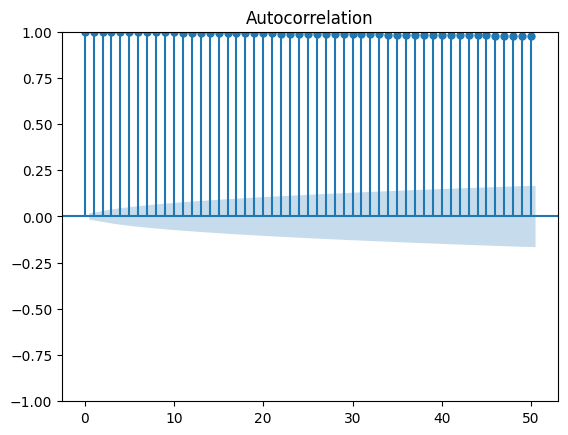

[1.         0.9995427  0.99911248 0.99868447 0.99825643 0.99782698
 0.99738089 0.99695761 0.99651308 0.99607763 0.99561118]


In [243]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [244]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


open          high           low         close      adjclose  \
count  13520.000000  13520.000000  13520.000000  13520.000000  13520.000000   
mean       0.308530      0.303586      0.300666      0.303553      0.303553   
std       15.617748     13.510293     15.293665     17.143004     17.143004   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.539978     -1.680000     -1.860001     -1.860001   
50%        0.000000      0.109993      0.190002      0.139999      0.139999   
75%        2.932617      2.469971      2.819992      2.910004      2.910004   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.352000e+04  
mean   3.130155e+05  
std    4.457372e+08  
min   -5.044220e+09  
25%   -3.891000e+07  
50%    1.000000e+04  
75%    3.769500e+07  
max    4.637230e+09

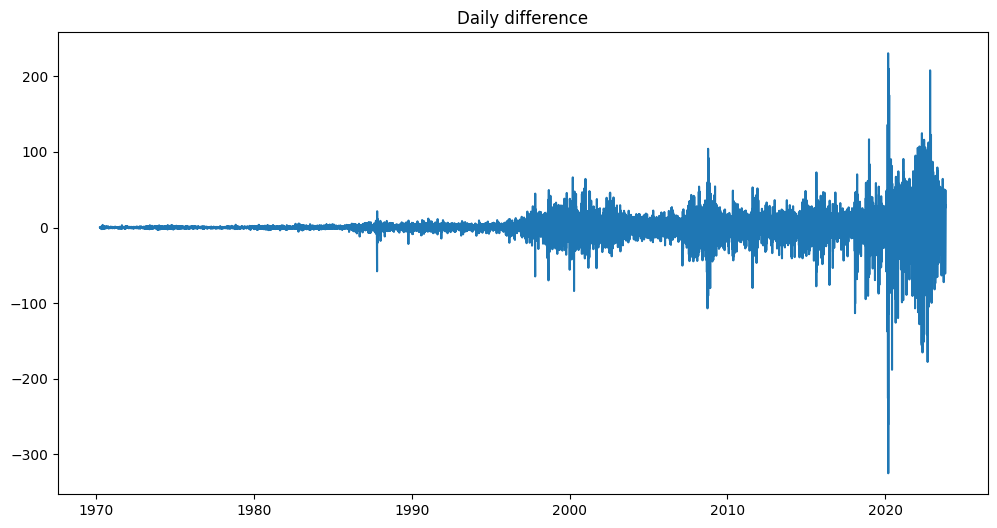

In [245]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [246]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -19.677983066451237
p-value: 0.0
Critical Values: {'1%': -3.430835275699234, '5%': -2.8617544690875487, '10%': -2.5668841570272822}
The time series is stationary.


KPSS Statistic: 0.5322118714000466
p-value: 0.03441174067566519
The time series is non-stationary.


## ACF of daily differences

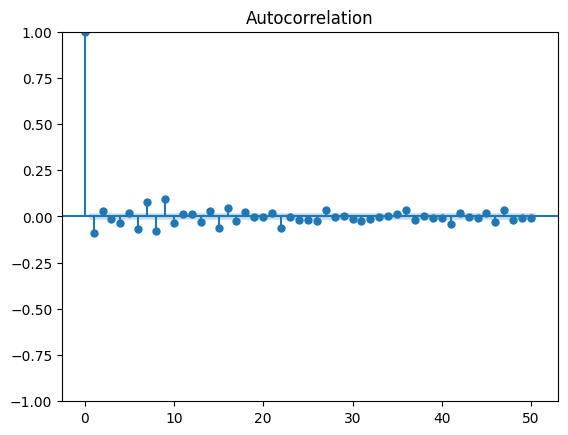

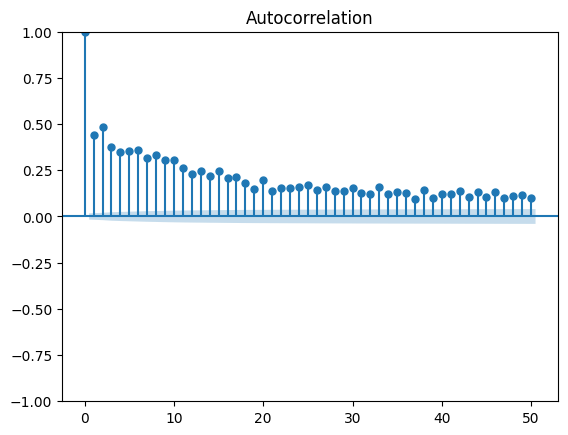

In [247]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

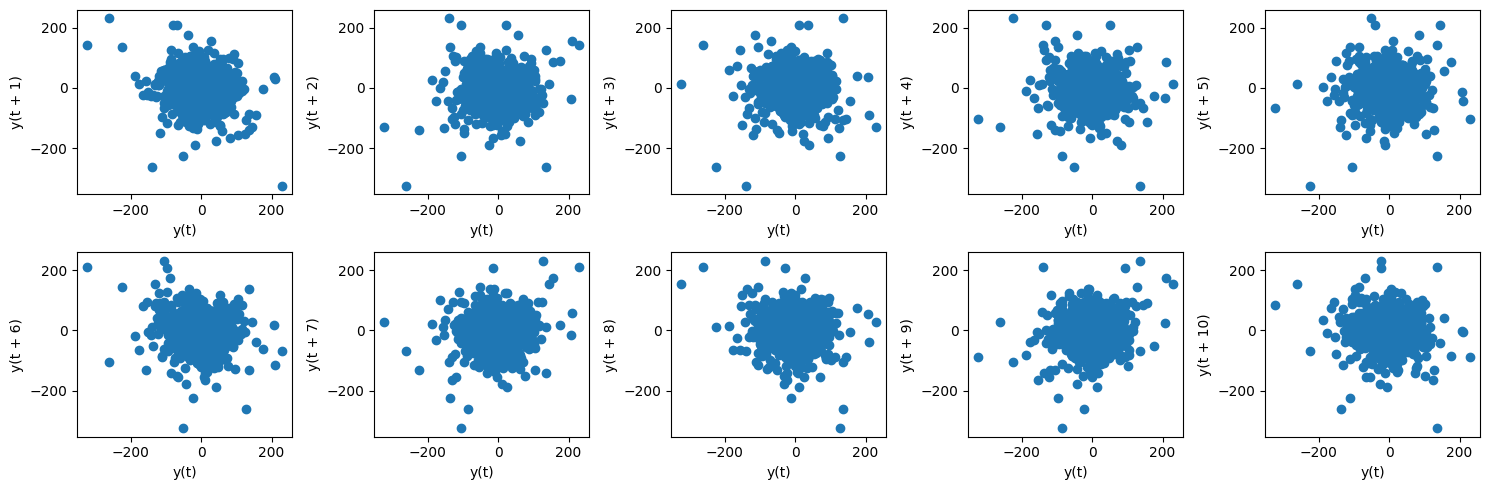

In [248]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

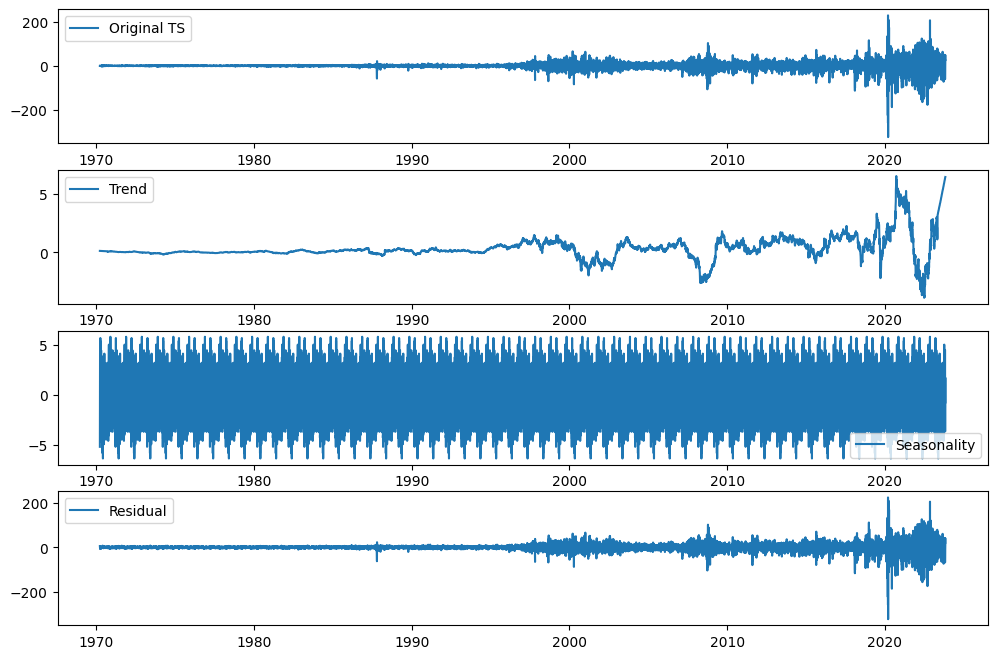

In [249]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

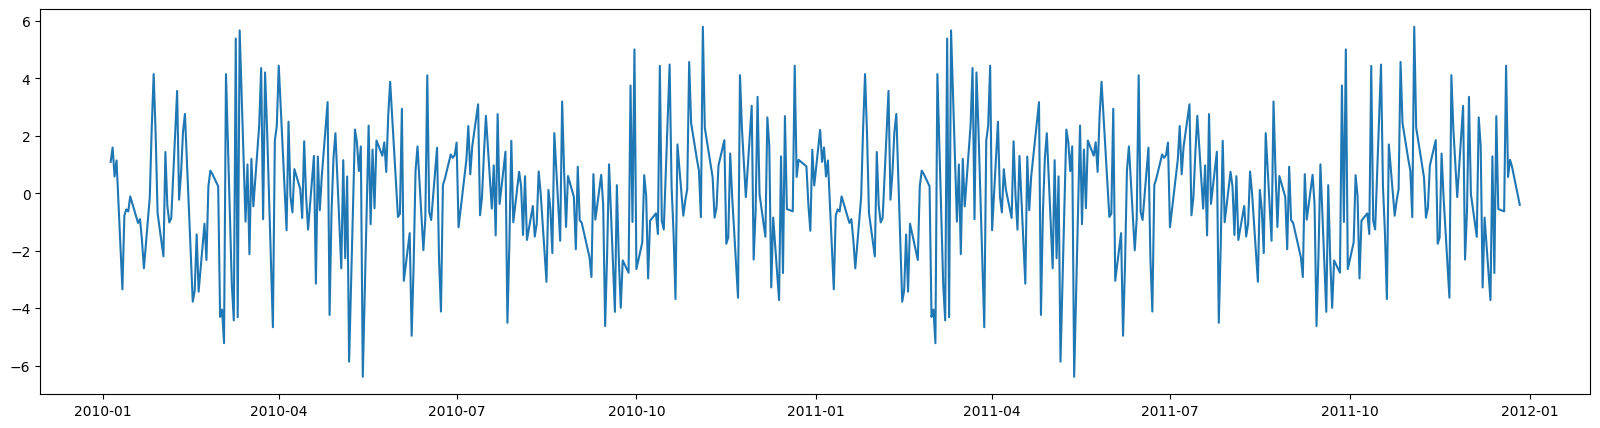

In [250]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

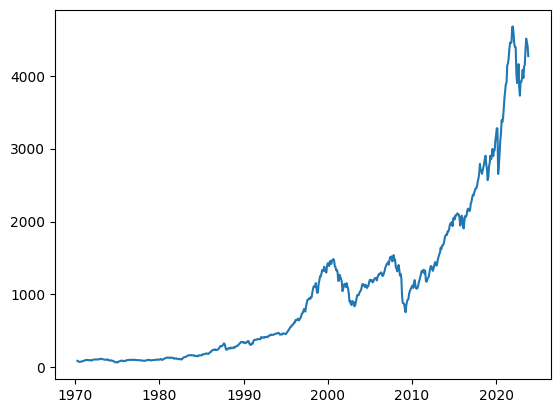

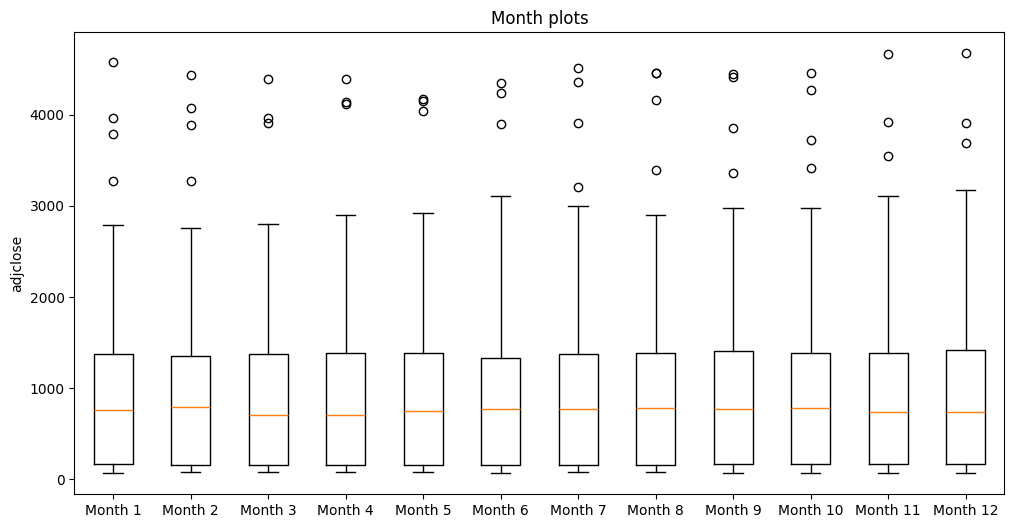

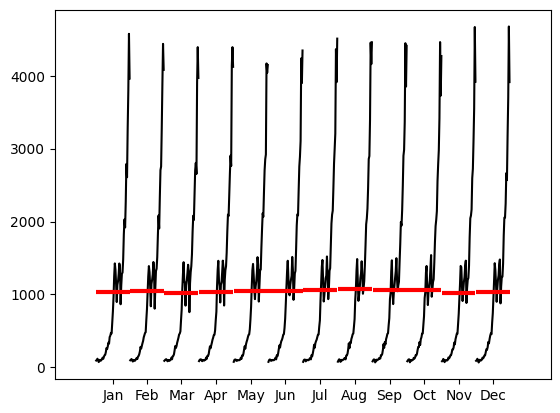

In [251]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

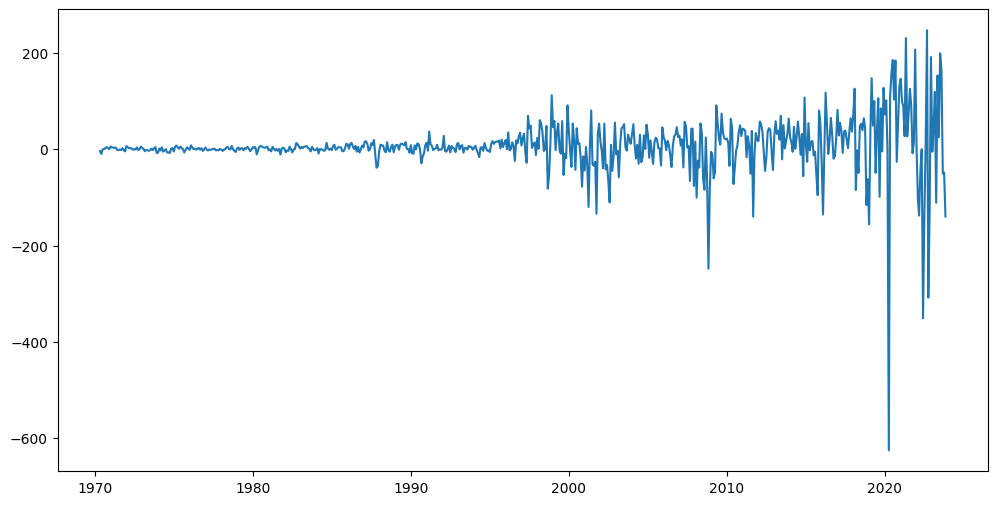

In [252]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

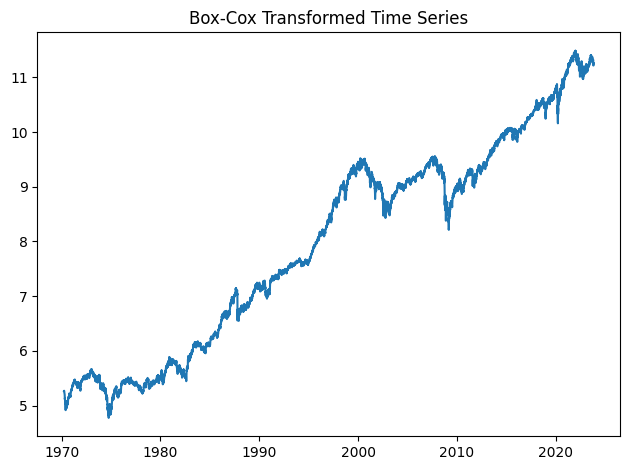

Optimal lambda value: 0.06844865164070166


In [253]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

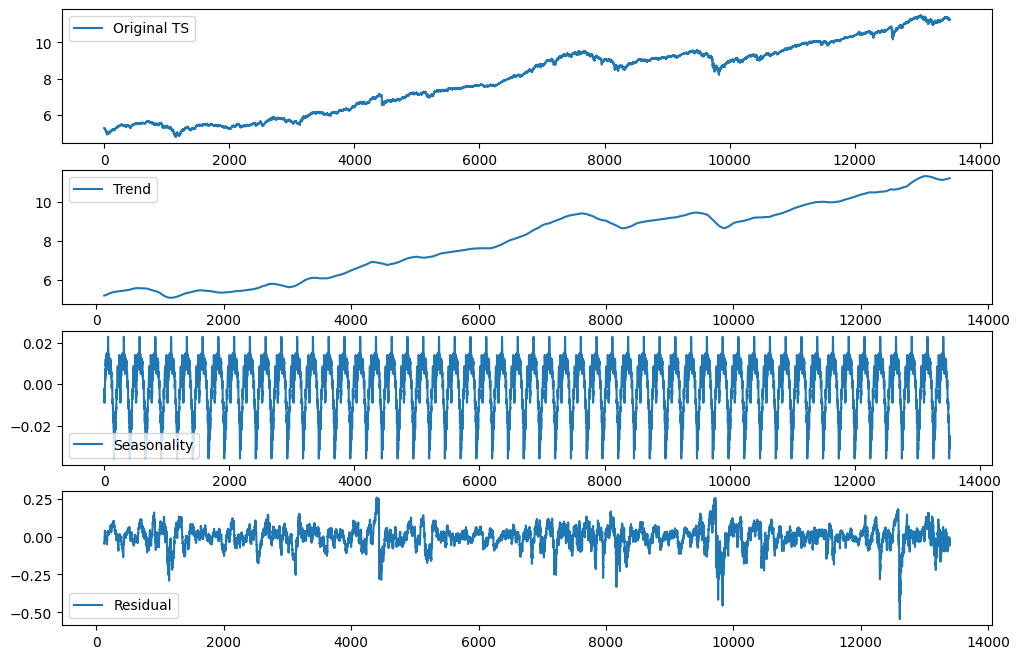

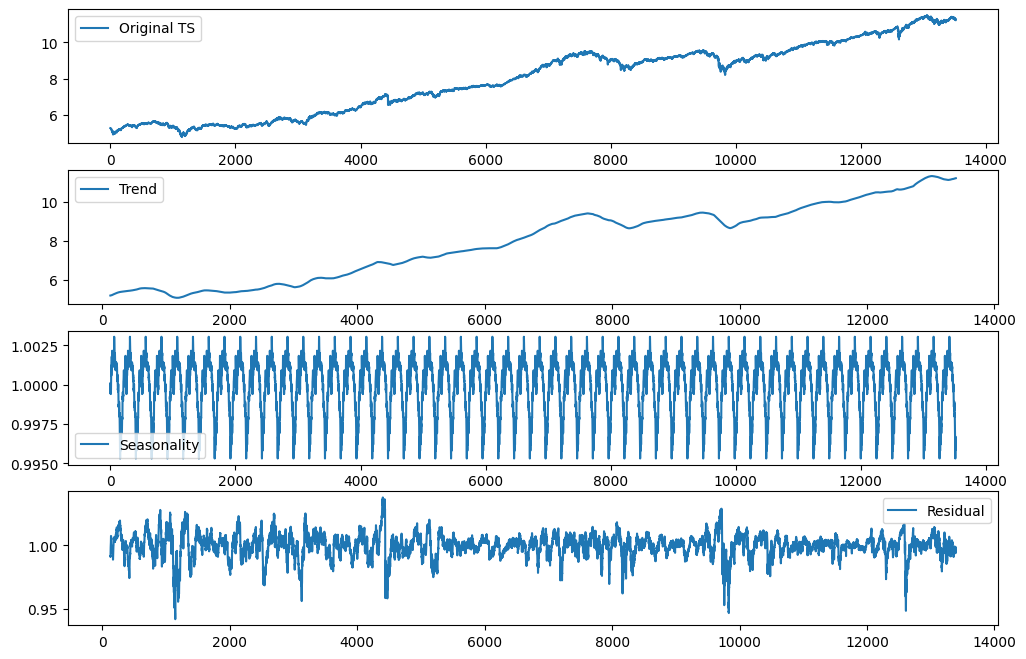

In [254]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

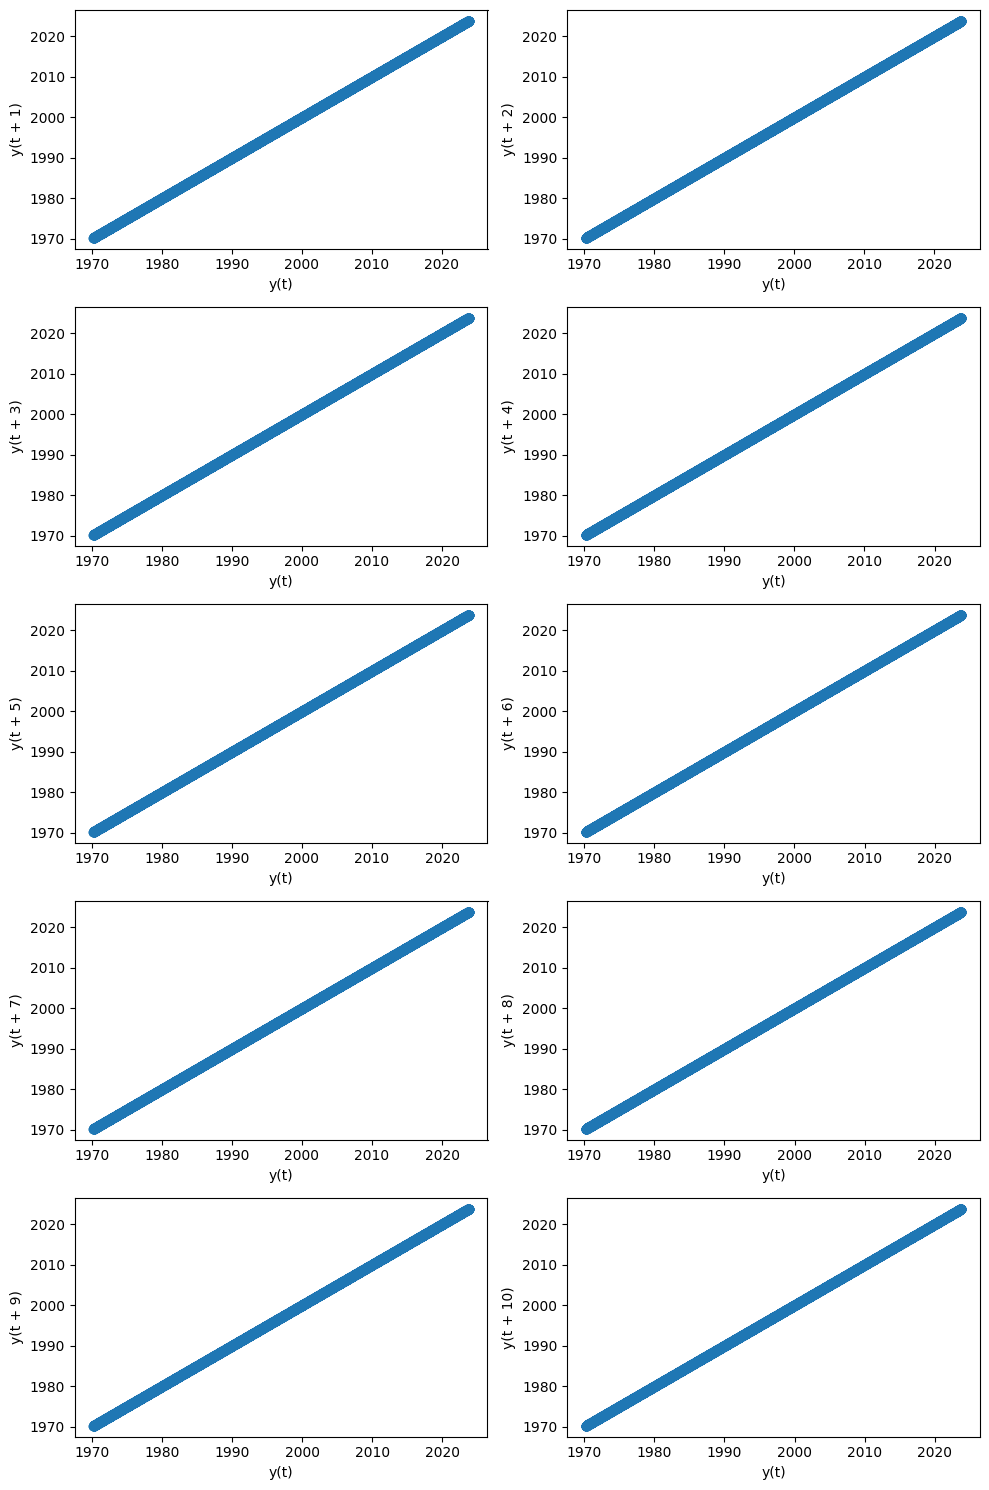

In [255]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

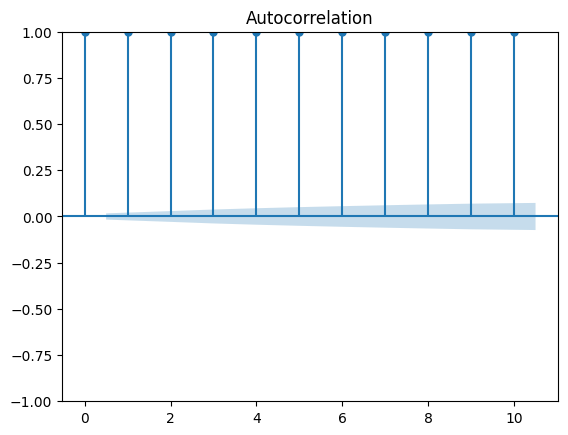

In [256]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [257]:
daily_diff.describe()

open          high           low         close      adjclose  \
count  13520.000000  13520.000000  13520.000000  13520.000000  13520.000000   
mean       0.308530      0.303586      0.300666      0.303553      0.303553   
std       15.617748     13.510293     15.293665     17.143004     17.143004   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.539978     -1.680000     -1.860001     -1.860001   
50%        0.000000      0.109993      0.190002      0.139999      0.139999   
75%        2.932617      2.469971      2.819992      2.910004      2.910004   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.352000e+04  
mean   3.130155e+05  
std    4.457372e+08  
min   -5.044220e+09  
25%   -3.891000e+07  
50%    1.000000e+04  
75%    3.769500e+07  
max    4.637230e+09

# Model

Conditional Variance:

The GARCH model assumes that the variance of the financial time series is not constant over time but depends on past observations. The conditional variance at each time point is the estimated volatility given the available information up to that point.

Volatility:

In the GARCH context, volatility is often used interchangeably with conditional variance. It characterizes the magnitude of potential fluctuations in the returns of a financial asset.

In [258]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

date
1970-03-26    0.167095
1970-03-30   -0.322510
1970-03-31    0.000000
1970-04-01    0.490910
1970-04-02   -0.310868
                ...   
2023-10-25   -1.433963
2023-10-26   -1.183252
2023-10-27   -0.480028
2023-10-30    1.201002
2023-10-31    0.647496
Name: adjclose, Length: 13520, dtype: float64


Returns


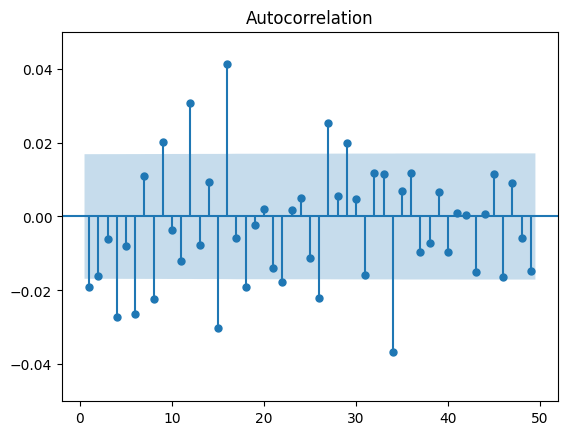

[ 1.         -0.0190007  -0.01623228 -0.00621788 -0.02712062 -0.00791244
 -0.02633619  0.01088753 -0.02243131  0.0201816  -0.00356244]


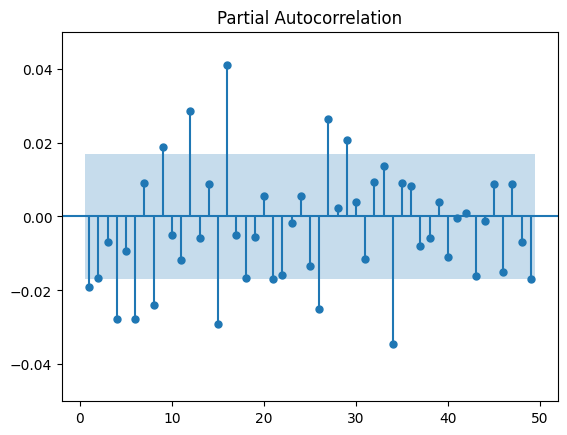

[ 1.         -0.01900211 -0.01660176 -0.0068527  -0.02767029 -0.00921373
 -0.02769024  0.00916974 -0.02391587  0.01882717 -0.00508953]


In [259]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


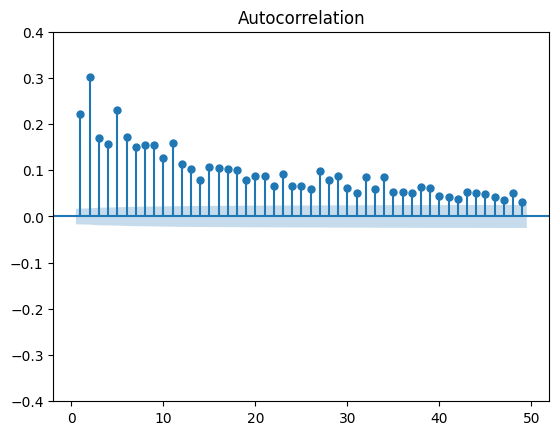

[1.         0.22136261 0.30174867 0.16878635 0.15717341 0.23095333
 0.1718736  0.15126323 0.15466593 0.1553499  0.12710189]


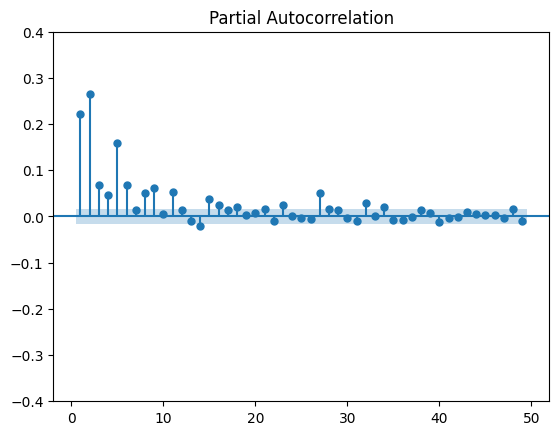

[1.         0.22137898 0.26581174 0.06893774 0.04635513 0.15817086
 0.06793851 0.0139008  0.05029142 0.06208783 0.00600577]


In [260]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

The ACF and PACF of the returns are similar to white nois white noise but have more correlation.

The ACF and PACF of the squared returns appear to be from an AR(2) model in that the PACF cuts off at lag 2, whereas the ACF is tailing off.

                            AutoReg Model Results                             
Dep. Variable:               adjclose   No. Observations:                13520
Model:                     AutoReg(2)   Log Likelihood              -20301.171
Method:               Conditional MLE   S.D. of innovations              1.086
Date:                Tue, 16 Jan 2024   AIC                          40610.343
Time:                        21:22:16   BIC                          40640.390
Sample:                             2   HQIC                         40620.363
                                13520                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0356      0.009      3.808      0.000       0.017       0.054
adjclose.L1    -0.0193      0.009     -2.246      0.025      -0.036      -0.002
adjclose.L2    -0.0166      0.009     -1.930    

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


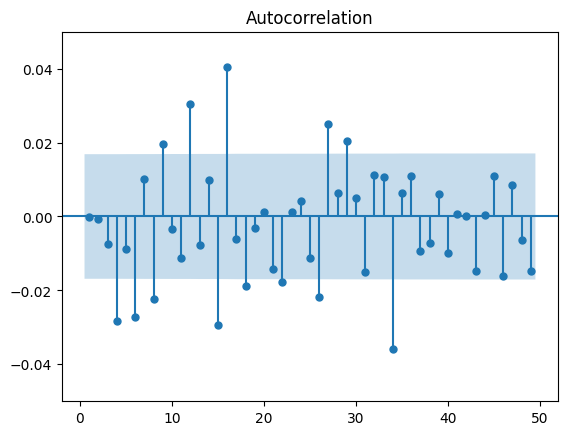

[ 1.00000000e+00 -1.14607776e-04 -5.78977851e-04 -7.53566711e-03
 -2.81456017e-02 -8.90454130e-03 -2.71363990e-02  1.01481281e-02
 -2.23430389e-02  1.96739377e-02 -3.27871433e-03]


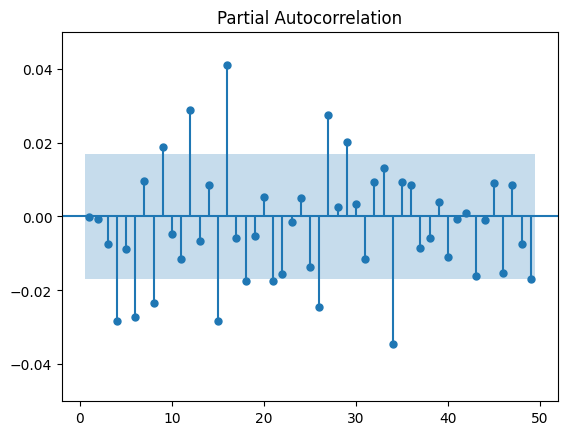

[ 1.00000000e+00 -1.14616255e-04 -5.79076668e-04 -7.53747525e-03
 -2.81576391e-02 -8.93684736e-03 -2.72718918e-02  9.69545902e-03
 -2.33682518e-02  1.88188801e-02 -4.82660724e-03]


In [261]:
model_ar = AutoReg(returns,lags=2)
results = model_ar.fit()

print(results.summary())

acf= sm.tsa.acf(results.resid,nlags=10)
fig = tsaplots.plot_acf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(results.resid,nlags=10)
fig = tsaplots.plot_pacf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17712.1
Distribution:                  Normal   AIC:                           35432.1
Method:            Maximum Likelihood   BIC:                           35462.2
                                        No. Observations:                13518
Date:                Tue, Jan 16 2024   Df Residuals:                    13517
Time:                        21:22:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0216  7.156e-03      3.018  2.545e-03 [7.

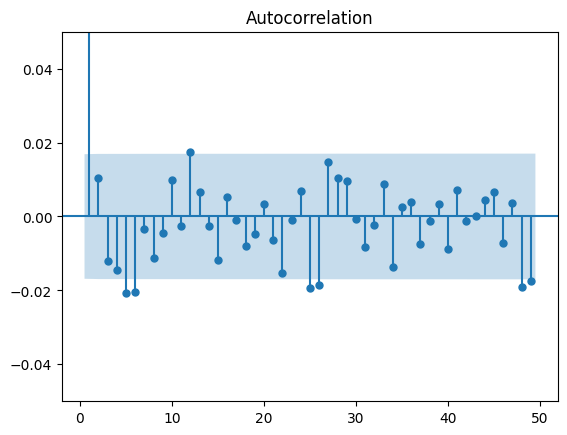

[ 1.          0.0668123   0.01040121 -0.01209873 -0.01446769 -0.02076839
 -0.02049714 -0.00351189 -0.01116562 -0.0045799   0.00986388]


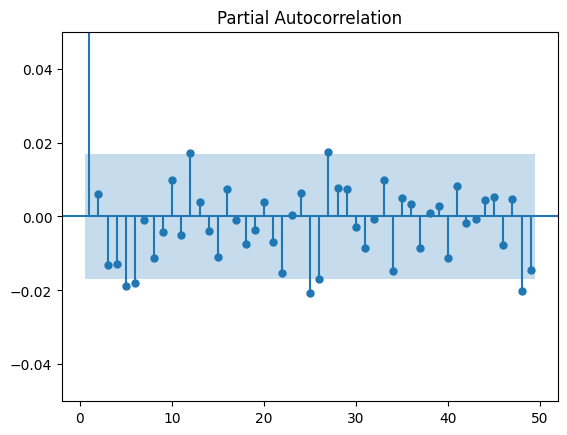

[ 1.00000000e+00  6.68172459e-02  5.96483811e-03 -1.32505384e-02
 -1.29134645e-02 -1.88317016e-02 -1.78980390e-02 -9.76848100e-04
 -1.12600989e-02 -4.07015144e-03  9.76700695e-03]


In [262]:
model_ar_garch = arch_model(results.resid,vol='GARCH',p=1,q=1)
result_ar_garch = model_ar_garch.fit(disp='off')

print(result_ar_garch.summary())

acf= sm.tsa.acf(result_ar_garch.std_resid,nlags=10)
tsaplots.plot_acf(result_ar_garch.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result_ar_garch.std_resid,nlags=10)
tsaplots.plot_pacf(result_ar_garch.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

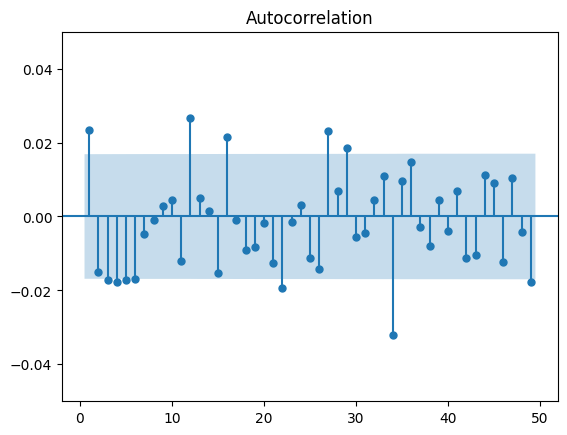

[ 1.00000000e+00  2.34647950e-02 -1.51573524e-02 -1.71289824e-02
 -1.76021571e-02 -1.72254059e-02 -1.69271235e-02 -4.70064973e-03
 -9.88191377e-04  2.90507599e-03  4.51344864e-03]


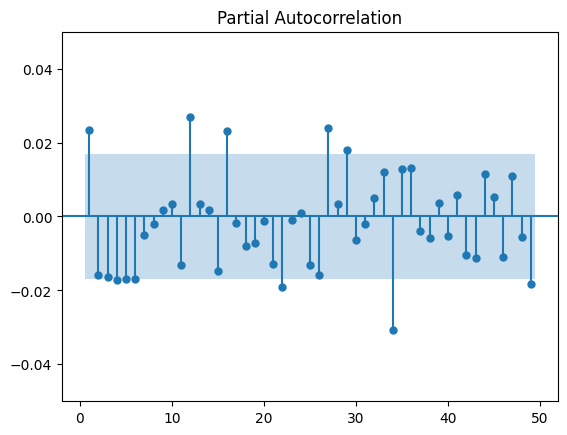

[ 1.          0.02346653 -0.01571893 -0.01641567 -0.01706877 -0.0169539
 -0.01697917 -0.00504066 -0.00217044  0.00167176  0.00333293]


In [263]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit(disp='off')

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

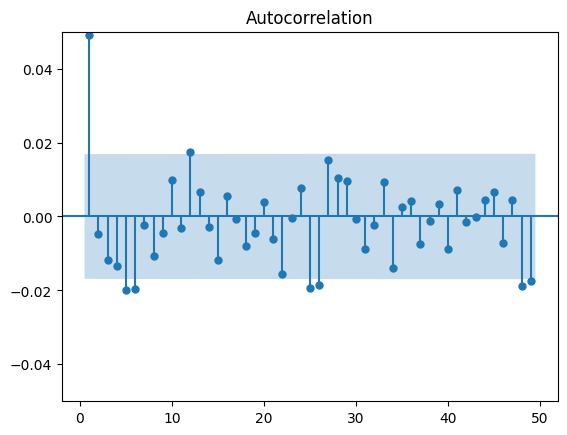

[ 1.          0.04910527 -0.00476818 -0.01184347 -0.01335559 -0.01975971
 -0.01962155 -0.00240486 -0.01067798 -0.00440786  0.00977895]


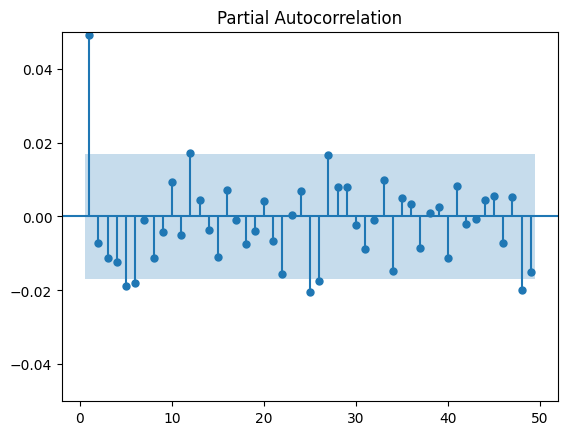

[ 1.          0.0491089  -0.00719793 -0.01128453 -0.01228388 -0.01868768
 -0.01807415 -0.00107546 -0.01136171 -0.00427252  0.00925001]


In [264]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model_garch.fit(disp='off')

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

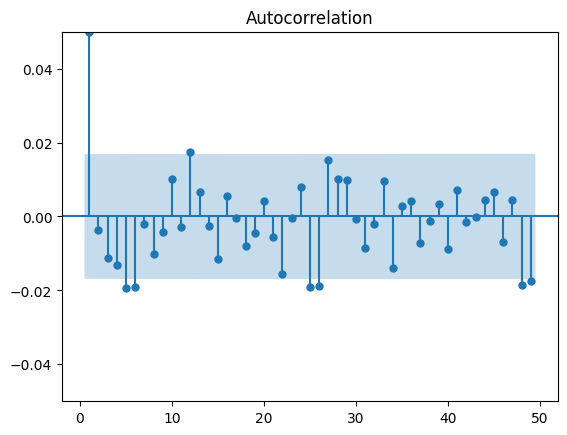

[ 1.          0.04991    -0.00370867 -0.01110573 -0.0130253  -0.01921949
 -0.01914767 -0.00192902 -0.01013198 -0.00413916  0.01022965]


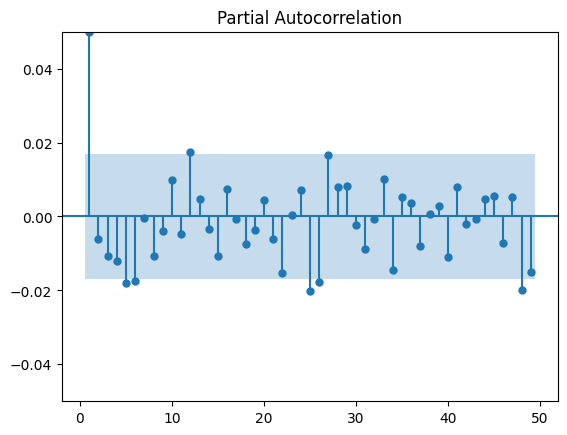

[ 1.00000000e+00  4.99136894e-02 -6.21607783e-03 -1.06385469e-02
 -1.19937501e-02 -1.81277013e-02 -1.75794261e-02 -5.46877599e-04
 -1.07707736e-02 -3.96992955e-03  9.76766703e-03]


In [265]:
log_returns = np.log(df['adjclose']/df['adjclose'].shift(1))[1:] *100

model_log_garch = arch_model(log_returns,vol='GARCH',p=1,q=1)
results_log_garch = model_log_garch.fit(disp='off')

acf= sm.tsa.acf(results_log_garch.std_resid,nlags=10)
tsaplots.plot_acf(results_log_garch.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(results_log_garch.std_resid,nlags=10)
tsaplots.plot_pacf(results_log_garch.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

After this analysis lets compare some garch models to make sure that we have the best fitt for our data

In [292]:
model_ar1 = AutoReg(returns,lags=1)
residuals1 = model_ar1.fit().resid
model1 = arch_model(residuals1,vol="GARCH",p=1,q=1)
results1 = model1.fit(disp='off')

model_ar2 = AutoReg(returns,lags=2)
residuals2 = model_ar2.fit().resid
model2 = arch_model(residuals2,vol="GARCH",p=1,q=1)
results2 = model2.fit(disp='off')

model_ar3 = AutoReg(returns,lags=3)
residuals3 = model_ar3.fit().resid
model3 = arch_model(residuals3,vol="GARCH",p=1,q=1)
results3 = model3.fit(disp='off')

model_ar4 = AutoReg(returns,lags=4)
residuals4 = model_ar4.fit().resid
model4 = arch_model(residuals4,vol="GARCH",p=1,q=1)
results4 = model4.fit(disp='off')

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

In [293]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print()
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print()
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35432.556389055106
35432.123829665026
35428.54221498973
35418.93060984741

35462.60379458456
35462.170939303665
35458.589028715665
35448.97712763875

-17712.278194527553
-17712.061914832513
-17710.271107494864
-17705.465304923706


In [294]:
model_ar1 = AutoReg(returns,lags=4)
residuals1 = model_ar1.fit().resid
model1 = arch_model(residuals1,vol="GARCH",p=1,q=1)
results1 = model1.fit(disp='off')

model_ar2 = AutoReg(returns,lags=4)
residuals2 = model_ar2.fit().resid
model2 = arch_model(residuals2,vol="GARCH",p=2,q=1)
results2 = model2.fit(disp='off')

model_ar3 = AutoReg(returns,lags=4)
residuals3 = model_ar3.fit().resid
model3 = arch_model(residuals3,vol="GARCH",p=3,q=1)
results3 = model3.fit(disp='off')

model_ar4 = AutoReg(returns,lags=4)
residuals4 = model_ar4.fit().resid
model4 = arch_model(residuals4,vol="GARCH",p=4,q=1)
results4 = model4.fit(disp='off')

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

In [295]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print()
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print()
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35418.93060984741
35420.93060984766
35422.93061004252
35424.93061014922

35448.97712763875
35458.48875708683
35468.00038672952
35477.51201628406

-17705.465304923706
-17705.46530492383
-17705.46530502126
-17705.46530507461


In [296]:
model_ar1 = AutoReg(returns,lags=4)
residuals1 = model_ar1.fit().resid
model1 = arch_model(residuals1,vol="GARCH",p=1,q=1)
results1 = model1.fit(disp='off')

model_ar2 = AutoReg(returns,lags=4)
residuals2 = model_ar2.fit().resid
model2 = arch_model(residuals2,vol="GARCH",p=1,q=2)
results2 = model2.fit(disp='off')

model_ar3 = AutoReg(returns,lags=4)
residuals3 = model_ar3.fit().resid
model3 = arch_model(residuals3,vol="GARCH",p=1,q=3)
results3 = model3.fit(disp='off')

model_ar4 = AutoReg(returns,lags=4)
residuals4 = model_ar4.fit().resid
model4 = arch_model(residuals4,vol="GARCH",p=1,q=4)
results4 = model4.fit(disp='off')

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

In [297]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print()
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print()
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35418.93060984741
35420.662439157706
35420.53040591457
35422.47950727287

35448.97712763875
35458.22058639688
35465.60018260158
35475.06091340771

-17705.465304923706
-17705.331219578853
-17704.265202957286
-17704.239753636433


After this comparisons we can see that the best GARCH model to model our data is GARCH(1,1)

# Final model

We divided our model in train and test sets

In [272]:
train_size = 0.8
train_data, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [273]:
model_ar = AutoReg(train_data,lags=2)
residuals = model_ar.fit().resid

model_final = arch_model(residuals,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14272.8
Distribution:                  Normal   AIC:                           28553.6
Method:            Maximum Likelihood   BIC:                           28582.8
                                        No. Observations:                10814
Date:                Tue, Jan 16 2024   Df Residuals:                    10813
Time:                        21:22:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0189  8.109e-03      2.331  1.977e-02 [3.

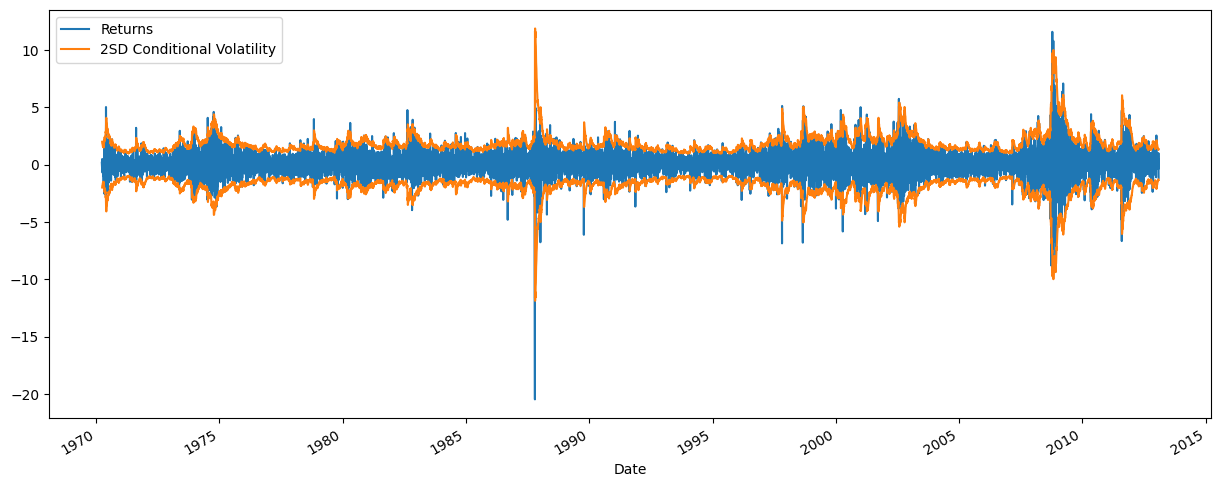

In [274]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

By the plot we can see that the model is fitting our data really well, to make sure that our model is appropriate we need to analyze the residuals.

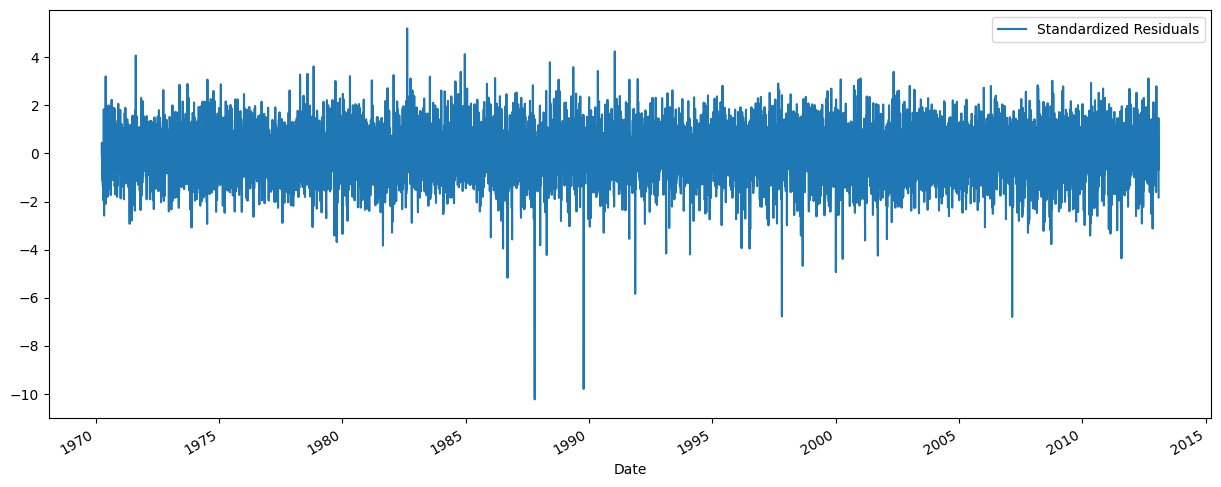

In [275]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

The plot of the residuals looks good. The residuals have a consistent mean and spread over time.

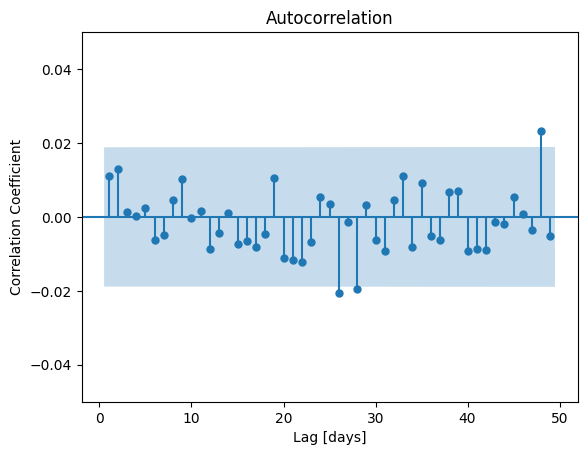

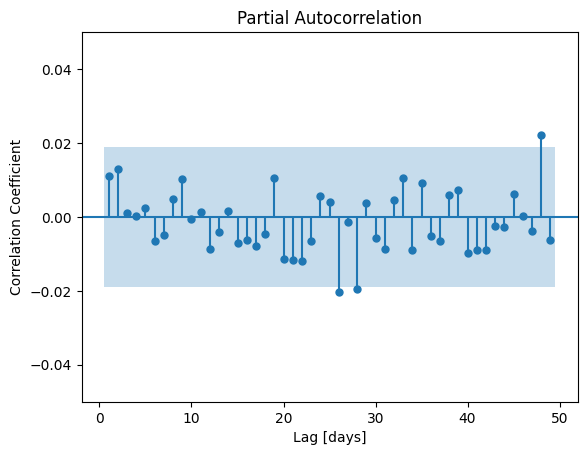

In [276]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

The ACF and PACF of the residuals look like white noise another sign that our model is able to explain the data.

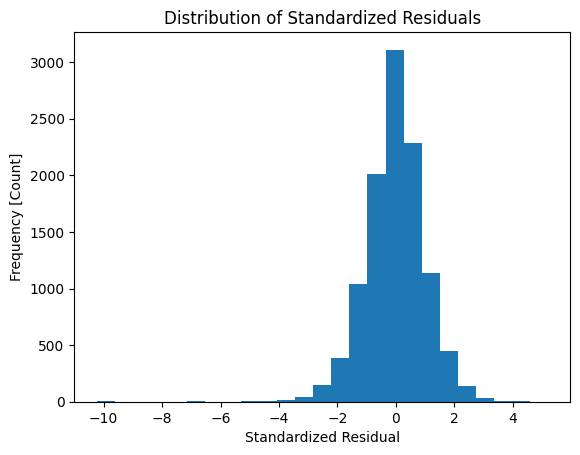

In [277]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

The histogram tells us that the residuals have a distribution simmilar to normal, to confirm this we will take a look at the density function compared to the density of a normal distribution.

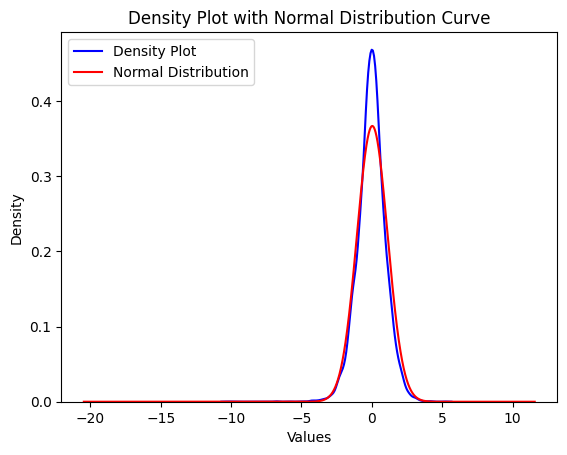

In [278]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

We can also look at the residuals over our fitted values and to a Q-Q plot of the residuals.

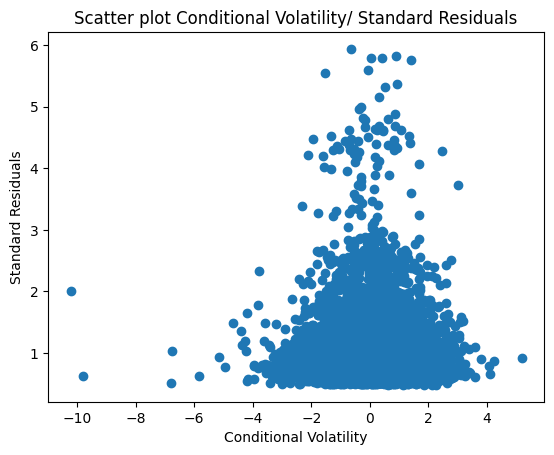

In [279]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

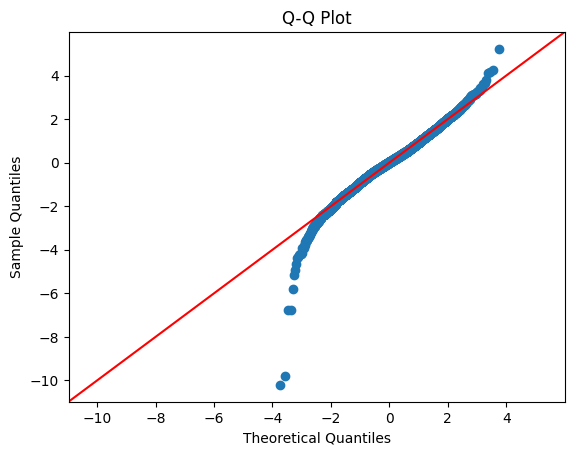

In [280]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

After analyzing this plots we can confidently say that the residuals of our model resemble white noise, a sign that our model is adequate for our data.

Finnaly lets take a look at the predicitons of our model

In [298]:
predictions = []

test_size = int(len(returns) *0.2)

for i in range(test_size):
    train_data_loop = returns.iloc[:-(test_size-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5
    
    predictions.append(next_pred)


c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

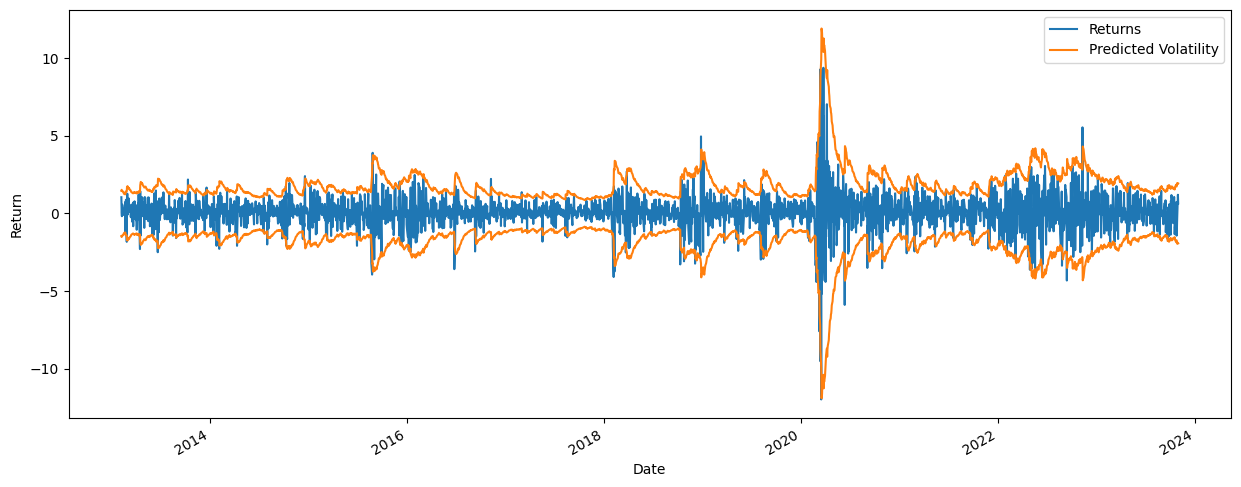

In [299]:
data_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [300]:
num_bootstrap_samples = 100

num_values = 10
table=[['observed','high_boot','low_boot','high_gaus','low_gaus']]

lower_boot = []
upper_boot = []

for i in range(num_values):
    train_data_loop = returns.iloc[:-(num_values-i)]

    model = arch_model(train_data_loop,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    residuals = results_arch.std_resid

    boot_sample = []

    for j in range(num_bootstrap_samples):
        sample = np.random.choice(residuals,size=len(residuals),replace=True)
        bootstrap_series = results_arch.conditional_volatility + sample
        
        model_boot = arch_model(bootstrap_series,vol='GARCH',p=1,q=1)
        results_boot = model_boot.fit(disp='off')

        forecast = results_boot.forecast(horizon=1,reindex=False)
        boot_pred = forecast.variance.iloc[0,0] ** 0.5

        boot_sample.append(boot_pred)    
    
    lower_boot.append(np.percentile(boot_sample,2.5,axis=0))
    upper_boot.append(np.percentile(boot_sample,97.5,axis=0))

for i in range(num_values):
    table.append([returns.iloc[len(returns)-num_values+i-1],2 * upper_boot[i],-2 * lower_boot[i],2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1],-2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1]])

print(tabulate(table, tablefmt="fancy_grid"))

╒═══════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ observed              │ high_boot          │ low_boot            │ high_gaus          │ low_gaus            │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.009824505308242415 │ 2.38294177845985   │ -1.8736651256970371 │ 1.608705084179502  │ -1.608705084179502  │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -1.3399820506516447   │ 2.43289620154226   │ -1.884231796370189  │ 1.5452398763717188 │ -1.5452398763717188 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.8482848196321058   │ 2.4455448000187605 │ -1.9064017451679593 │ 1.696132193338447  │ -1.696132193338447  │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼───────────────

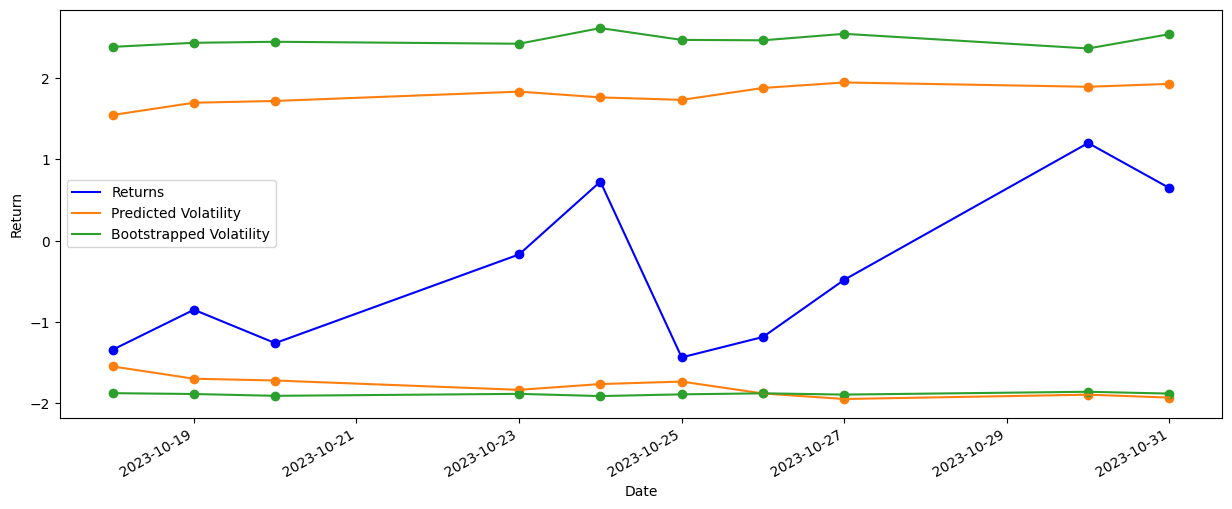

In [301]:
plt.subplots(figsize=(15, 6))
plt.scatter(x= returns.tail(num_values).index,y=returns.tail(num_values),color='blue')
plt.plot(returns.tail(num_values),label="Returns",color='blue')

(2 * data_test_wfv.tail(num_values)).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv.tail(num_values)).plot(c="C1")
plt.scatter(returns.tail(num_values).index,2 * data_test_wfv.tail(num_values),c="C1")
plt.scatter(returns.tail(num_values).index,-2 * data_test_wfv.tail(num_values),c="C1")

upper_boot = pd.Series(upper_boot, data_test_wfv.tail(num_values).index)
lower_boot = pd.Series(lower_boot, data_test_wfv.tail(num_values).index)

plt.plot(2 * upper_boot,c="C2", label="Bootstrapped Volatility")
plt.plot(-2 * lower_boot,c="C2")
plt.scatter(returns.tail(num_values).index,2 * upper_boot,c="C2")
plt.scatter(returns.tail(num_values).index,-2 *lower_boot,c="C2")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

The predictions shows us that the model was able to capture our data farily well, being able to represent periods of low or high volatility.

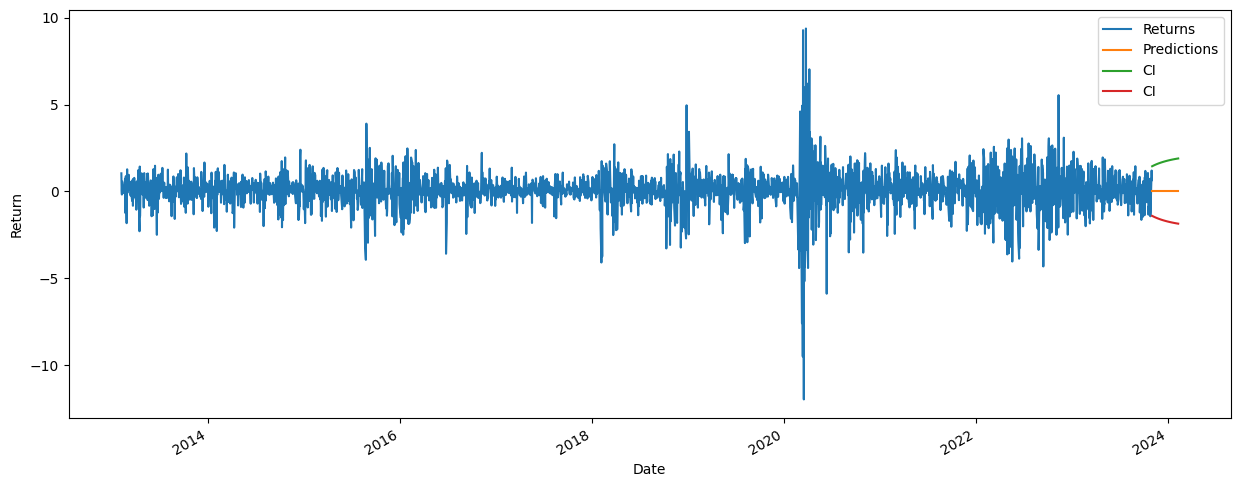

In [302]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = returns.tail(1).index

confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

## No outliers

In [358]:
z_score = stats.zscore(returns)
returns_no_out = returns[np.abs(z_score) < 2.5]

train_data,_ = train_test_split(returns_no_out, train_size=train_size, shuffle=False)
_, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [359]:
model_ar = AutoReg(train_data,lags=2)
residuals = model_ar.fit().resid

model_final = arch_model(residuals,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12826.5
Distribution:                  Normal   AIC:                           25660.9
Method:            Maximum Likelihood   BIC:                           25690.0
                                        No. Observations:                10554
Date:                Tue, Jan 16 2024   Df Residuals:                    10553
Time:                        22:45:15   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0105  7.425e-03      1.408      0.159 

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


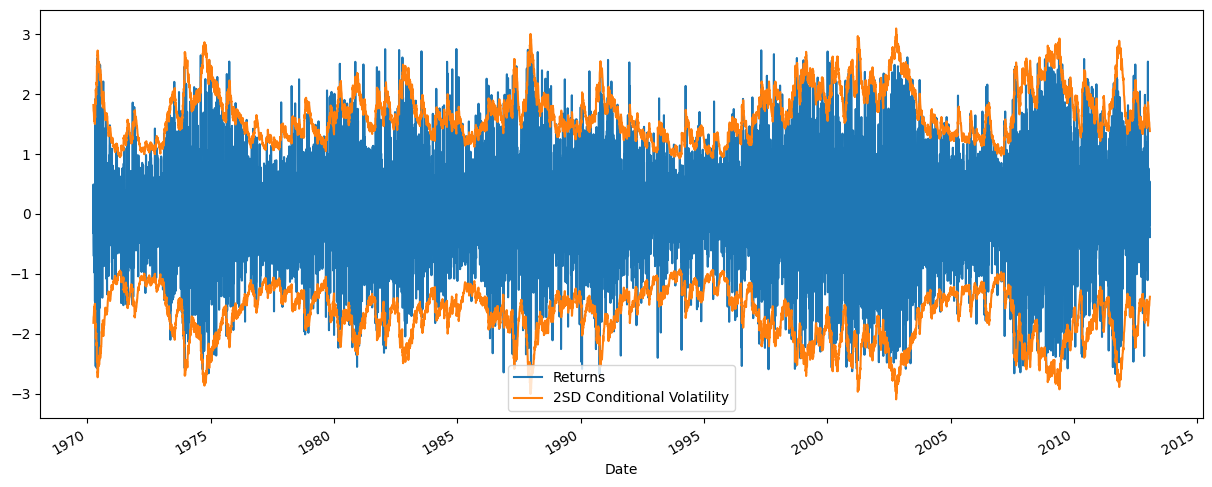

In [360]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

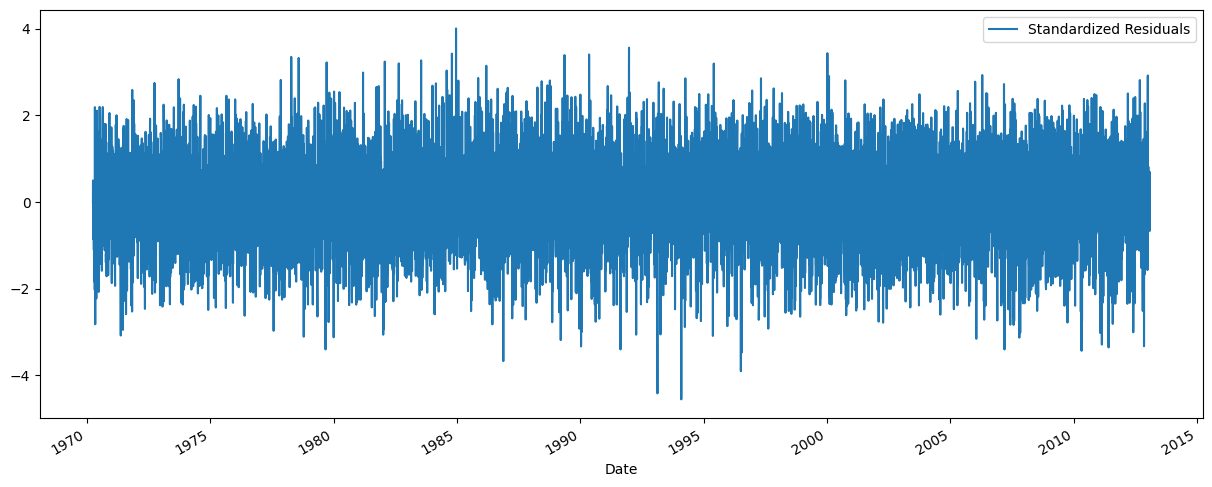

In [361]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

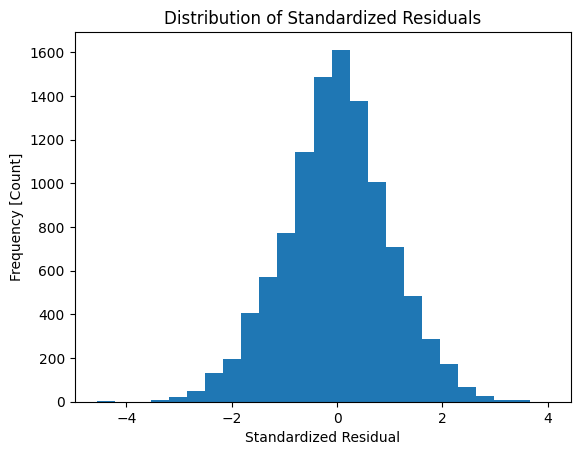

In [362]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

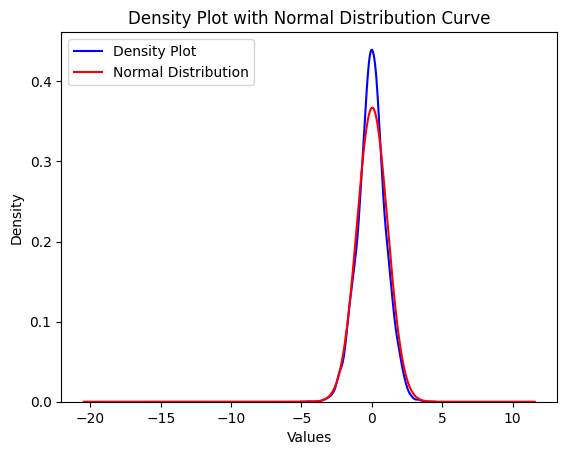

In [363]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

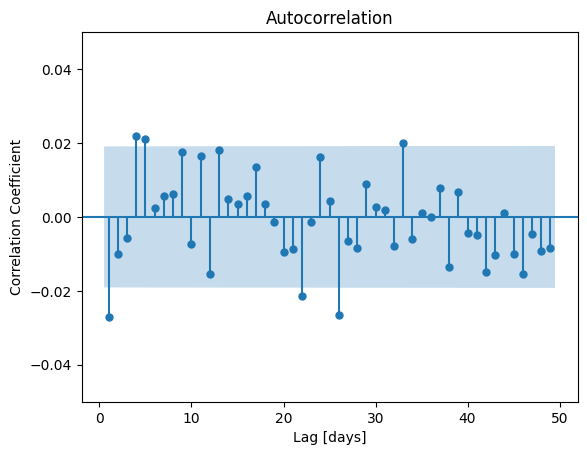

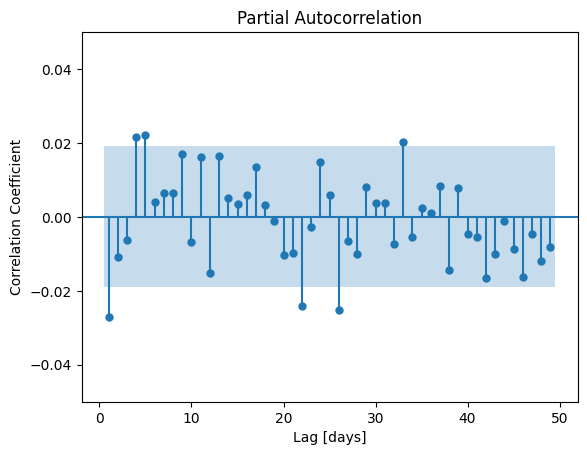

In [364]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

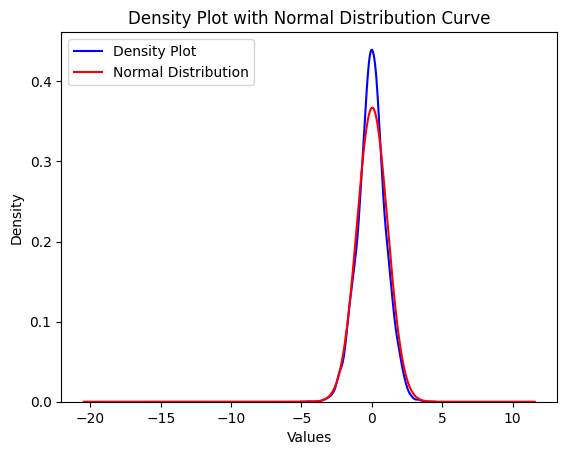

In [365]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

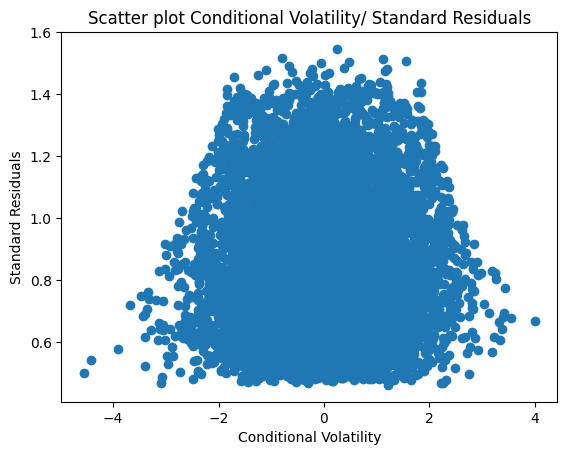

In [366]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

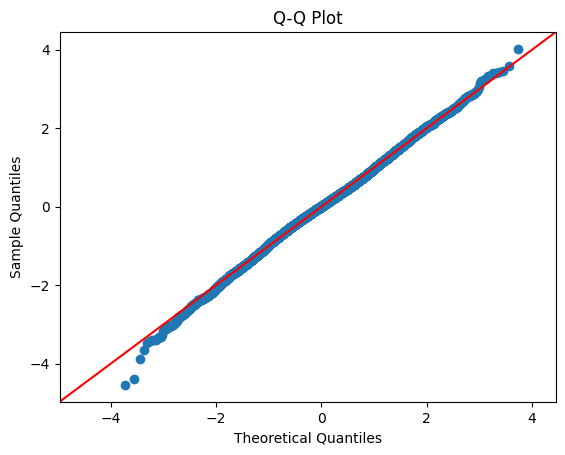

In [367]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

In [368]:
predictions = []

test_size = int(len(returns_no_out) *0.2)

for i in range(test_size):
    train_data_loop = returns_no_out.iloc[:-(test_size-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5

    predictions.append(next_pred)


c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

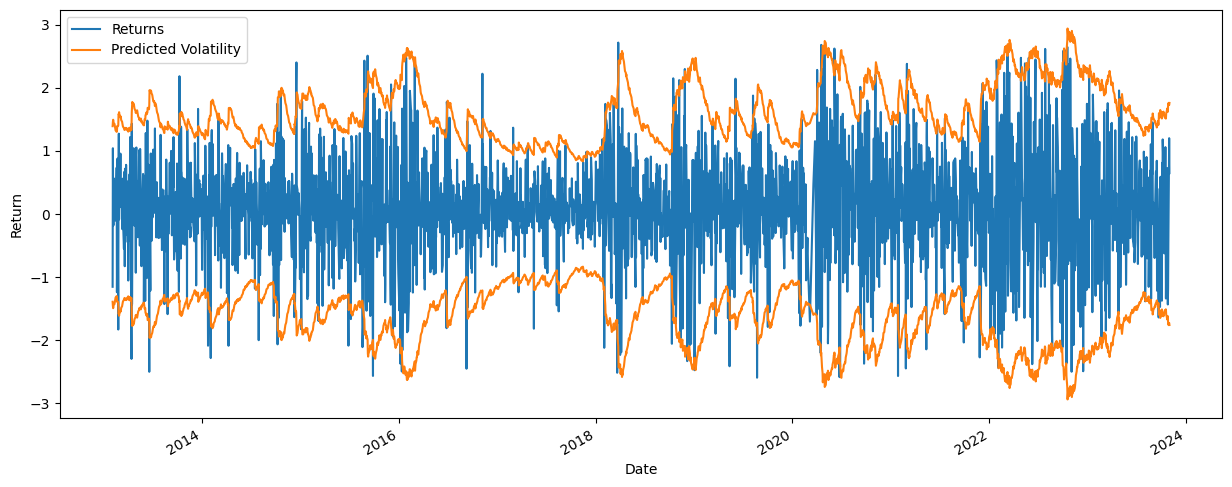

In [369]:
data_test_wfv = pd.Series(predictions, index=returns_no_out.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns_no_out.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [370]:
num_bootstrap_samples = 100

num_values = 10
table=[['observed','high_boot','low_boot','high_gaus','low_gaus']]

lower_boot = []
upper_boot = []

for i in range(num_values):
    train_data_loop = returns_no_out.iloc[:-(num_values-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    residuals = results_arch.std_resid

    boot_sample = []

    for j in range(num_bootstrap_samples):
        sample = np.random.choice(residuals,size=len(residuals),replace=True)
        bootstrap_series = results_arch.conditional_volatility + sample
        
        model_boot = arch_model(bootstrap_series,vol='GARCH',p=1,q=1)
        results_boot = model_boot.fit(disp='off')

        forecast = results_boot.forecast(horizon=1,reindex=False)
        boot_pred = forecast.variance.iloc[0,0] ** 0.5

        boot_sample.append(boot_pred)    
    
    lower_boot.append(np.percentile(boot_sample,2.5,axis=0))
    upper_boot.append(np.percentile(boot_sample,97.5,axis=0))

for i in range(num_values):
    table.append([returns_no_out.iloc[len(returns_no_out)-num_values+i-1],2 * upper_boot[i],-2 * lower_boot[i],2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1],-2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1]])

print(tabulate(table, tablefmt="fancy_grid"))

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

╒═══════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ observed              │ high_boot          │ low_boot            │ high_gaus          │ low_gaus            │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.009824505308242415 │ 2.099708365205269  │ -2.001669021020357  │ 1.54985499984042   │ -1.54985499984042   │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -1.3399820506516447   │ 2.0820798273117505 │ -2.0016905325213914 │ 1.5128843576948916 │ -1.5128843576948916 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.8482848196321058   │ 2.0980337738590324 │ -2.0053157499371372 │ 1.6002481215308308 │ -1.6002481215308308 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼───────────────

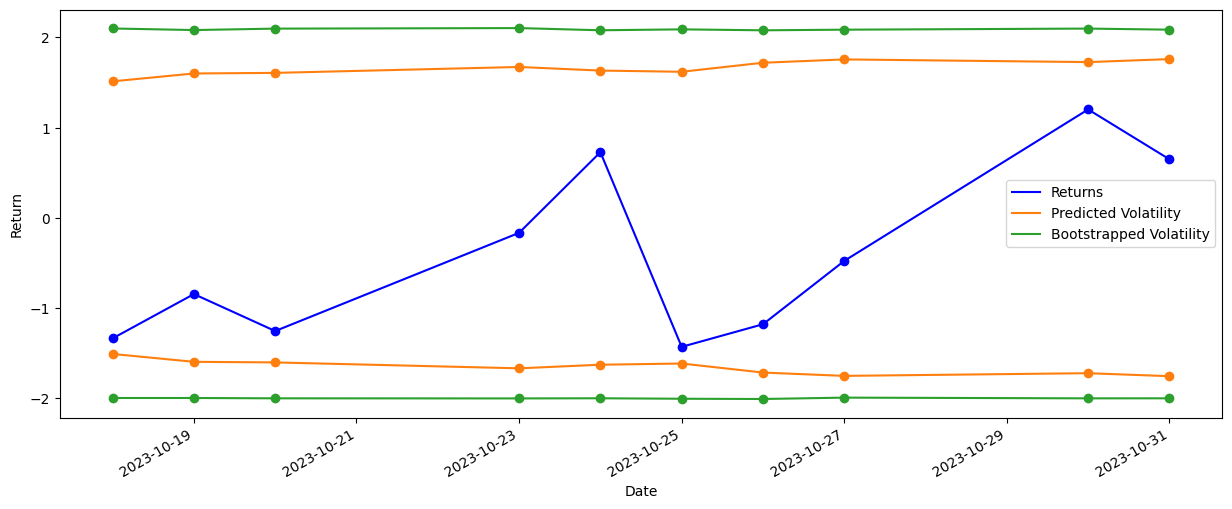

In [371]:
plt.subplots(figsize=(15, 6))
plt.scatter(x= returns_no_out.tail(num_values).index,y=returns_no_out.tail(num_values),color='blue')
plt.plot(returns_no_out.tail(num_values),label="Returns",color='blue')

(2 * data_test_wfv.tail(num_values)).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv.tail(num_values)).plot(c="C1")
plt.scatter(returns_no_out.tail(num_values).index,2 * data_test_wfv.tail(num_values),c="C1")
plt.scatter(returns_no_out.tail(num_values).index,-2 * data_test_wfv.tail(num_values),c="C1")

upper_boot = pd.Series(upper_boot, data_test_wfv.tail(num_values).index)
lower_boot = pd.Series(lower_boot, data_test_wfv.tail(num_values).index)

plt.plot(2 * upper_boot,c="C2", label="Bootstrapped Volatility")
plt.plot(-2 * lower_boot,c="C2")
plt.scatter(returns_no_out.tail(num_values).index,2 * upper_boot,c="C2")
plt.scatter(returns_no_out.tail(num_values).index,-2 *lower_boot,c="C2")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

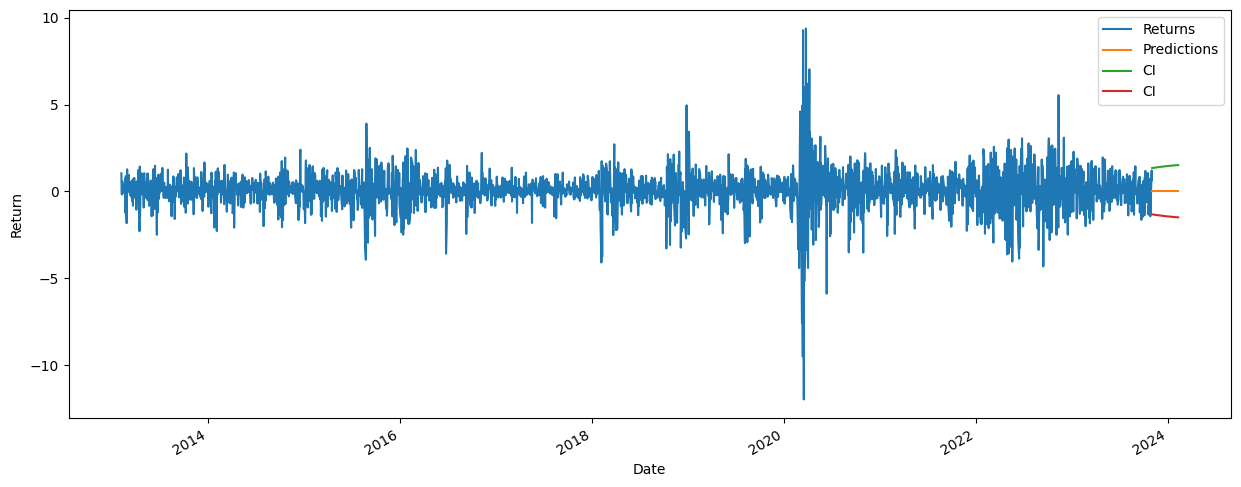

In [372]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = returns_no_out.tail(1).index
confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

## Log data

In [373]:
log_returns = np.log(df['adjclose']).pct_change().dropna() *1000

train_data, test_data = train_test_split(log_returns, train_size=train_size, shuffle=False)

In [374]:
model_ar = AutoReg(train_data,lags=2)
residuals = model_ar.fit().resid

model_final = arch_model(residuals,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20146.3
Distribution:                  Normal   AIC:                           40300.6
Method:            Maximum Likelihood   BIC:                           40329.8
                                        No. Observations:                10814
Date:                Tue, Jan 16 2024   Df Residuals:                    10813
Time:                        22:50:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0353  1.368e-02      2.580  9.880e-03 [8.

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


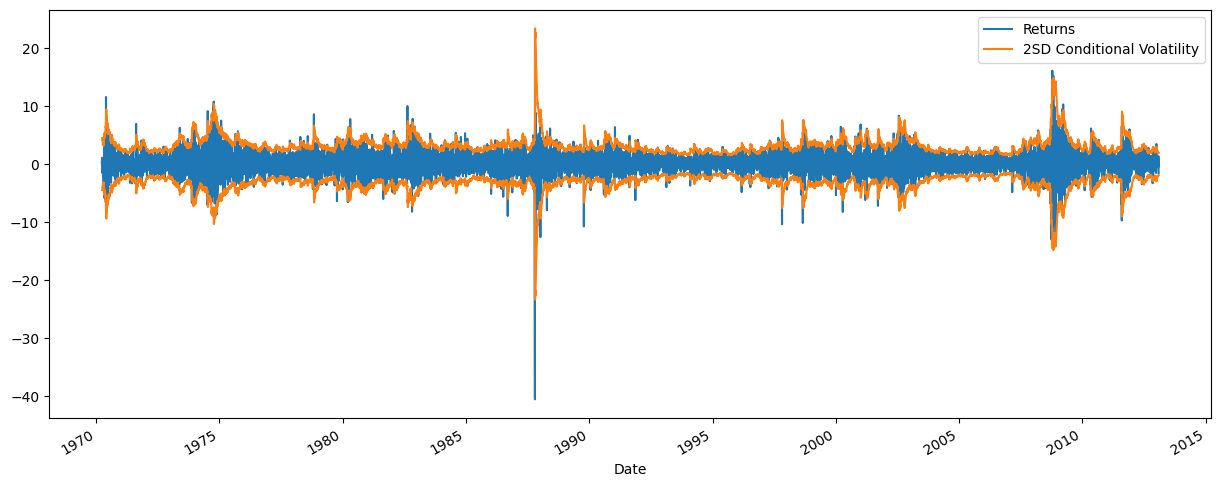

In [375]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

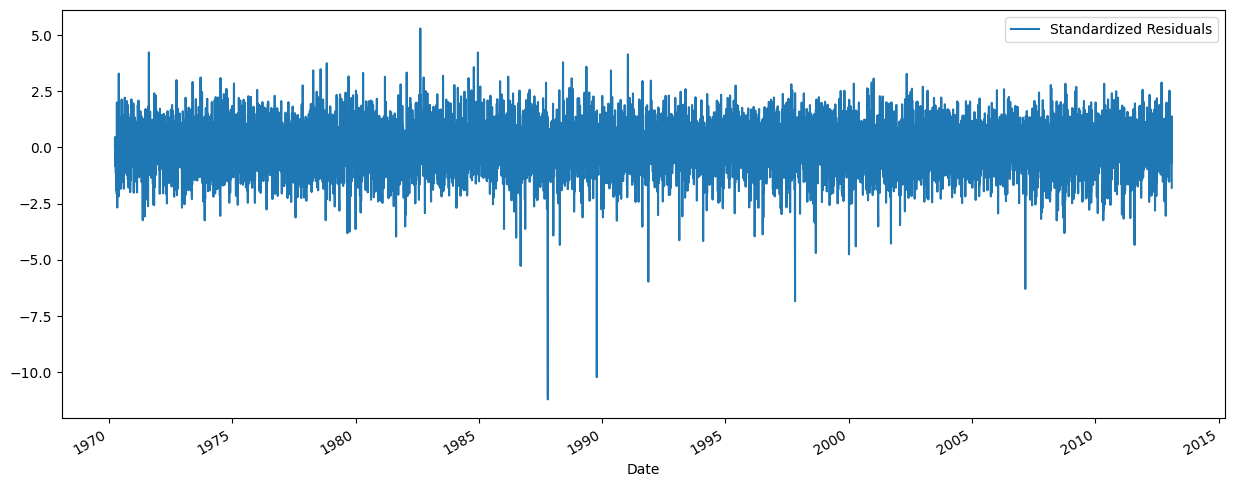

In [376]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

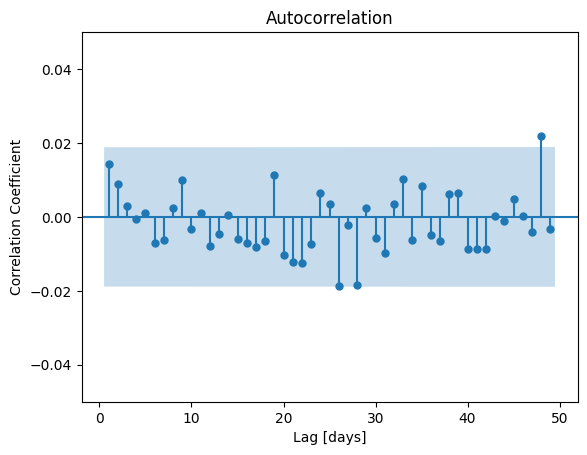

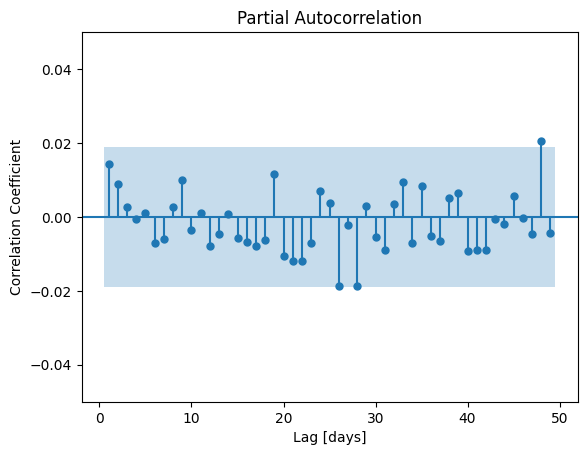

In [377]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

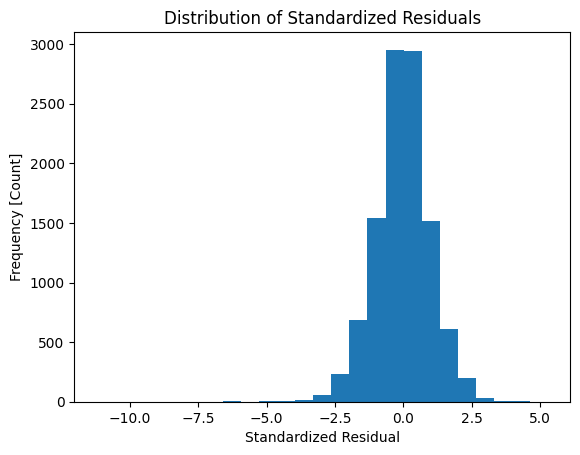

In [378]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

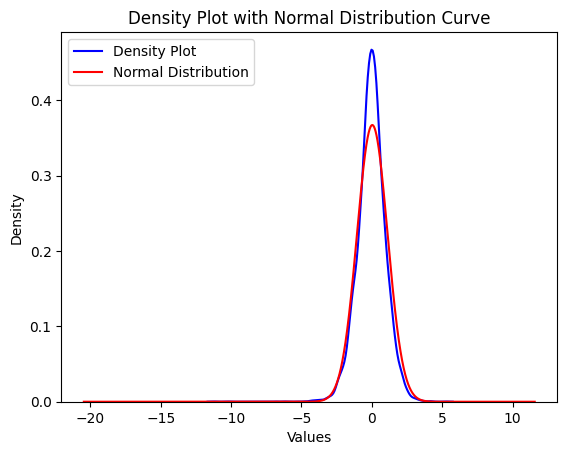

In [379]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

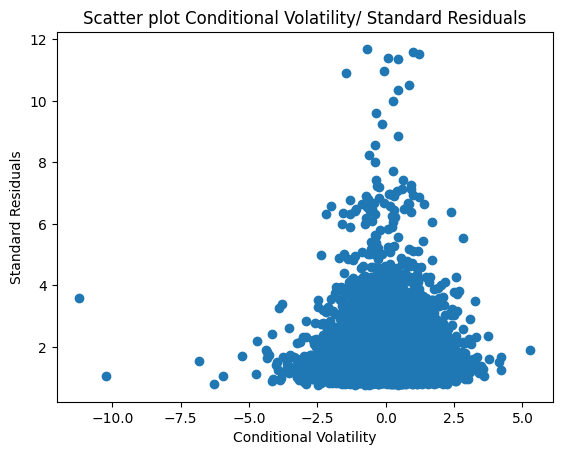

In [380]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

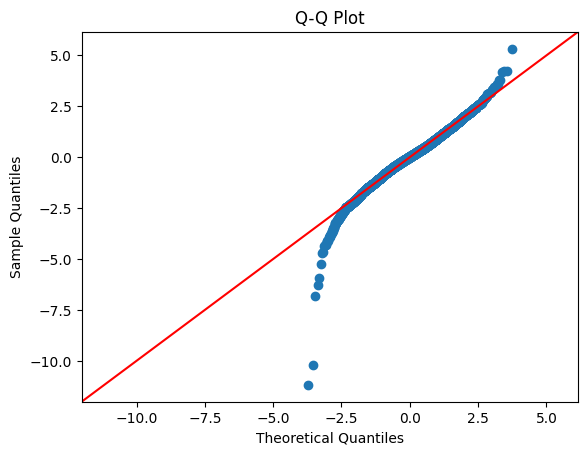

In [381]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

In [382]:
predictions = []

test_size = int(len(log_returns) *0.2)

for i in range(test_size):
    train_data_loop = log_returns.iloc[:-(test_size-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)

    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5

    predictions.append(next_pred)


c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

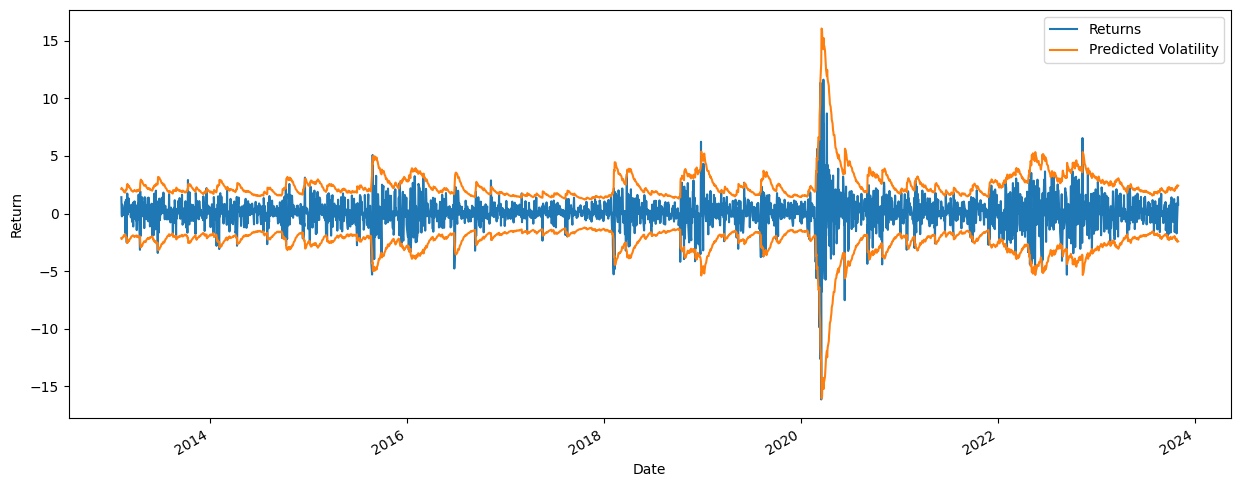

In [383]:
data_test_wfv = pd.Series(predictions, index=log_returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
log_returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [384]:
num_bootstrap_samples = 100

num_values = 10
table=[['observed','high_boot','low_boot','high_gaus','low_gaus']]

lower_boot = []
upper_boot = []

for i in range(num_values):
    train_data_loop = log_returns.iloc[:-(num_values-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    residuals = results_arch.std_resid

    boot_sample = []

    for j in range(num_bootstrap_samples):
        sample = np.random.choice(residuals,size=len(residuals),replace=True)
        bootstrap_series = results_arch.conditional_volatility + sample
        
        model_boot = arch_model(bootstrap_series,vol='GARCH',p=1,q=1)
        results_boot = model_boot.fit(disp='off')

        forecast = results_boot.forecast(horizon=1,reindex=False)
        boot_pred = forecast.variance.iloc[0,0] ** 0.5

        boot_sample.append(boot_pred)    
    
    lower_boot.append(np.percentile(boot_sample,2.5,axis=0))
    upper_boot.append(np.percentile(boot_sample,97.5,axis=0))

for i in range(num_values):
    table.append([log_returns.iloc[len(log_returns)-num_values+i-1],2 * upper_boot[i],-2 * lower_boot[i],2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1],-2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1]])

print(tabulate(table, tablefmt="fancy_grid"))

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

╒═══════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ observed              │ high_boot          │ low_boot            │ high_gaus          │ low_gaus            │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.011719646213714796 │ 2.751319815872602  │ -1.9593091474253033 │ 2.0531917153248473 │ -2.0531917153248473 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -1.6092097599087474   │ 3.042565324931117  │ -1.9131574664297184 │ 1.9824665983507586 │ -1.9824665983507586 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -1.0178347297269408   │ 2.8184642113235765 │ -1.9567911234957454 │ 2.1573343261549383 │ -2.1573343261549383 │
├───────────────────────┼────────────────────┼─────────────────────┼────────────────────┼───────────────

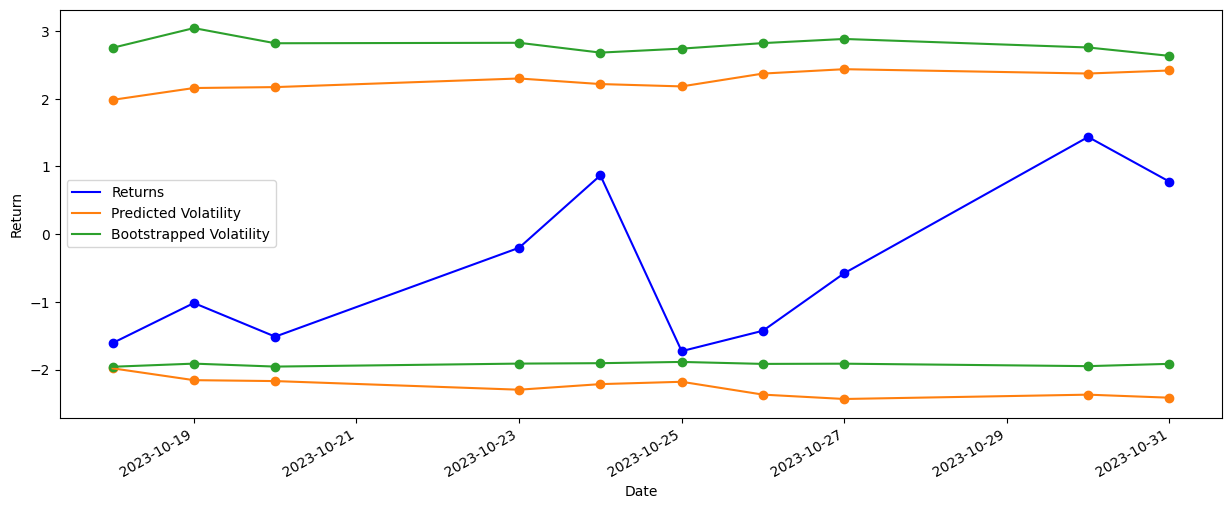

In [385]:
plt.subplots(figsize=(15, 6))
plt.scatter(x= log_returns.tail(num_values).index,y=log_returns.tail(num_values),color='blue')
plt.plot(log_returns.tail(num_values),label="Returns",color='blue')

(2 * data_test_wfv.tail(num_values)).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv.tail(num_values)).plot(c="C1")
plt.scatter(log_returns.tail(num_values).index,2 * data_test_wfv.tail(num_values),c="C1")
plt.scatter(log_returns.tail(num_values).index,-2 * data_test_wfv.tail(num_values),c="C1")

upper_boot = pd.Series(upper_boot, data_test_wfv.tail(num_values).index)
lower_boot = pd.Series(lower_boot, data_test_wfv.tail(num_values).index)

plt.plot(2 * upper_boot,c="C2", label="Bootstrapped Volatility")
plt.plot(-2 * lower_boot,c="C2")
plt.scatter(log_returns.tail(num_values).index,2 * upper_boot,c="C2")
plt.scatter(log_returns.tail(num_values).index,-2 *lower_boot,c="C2")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

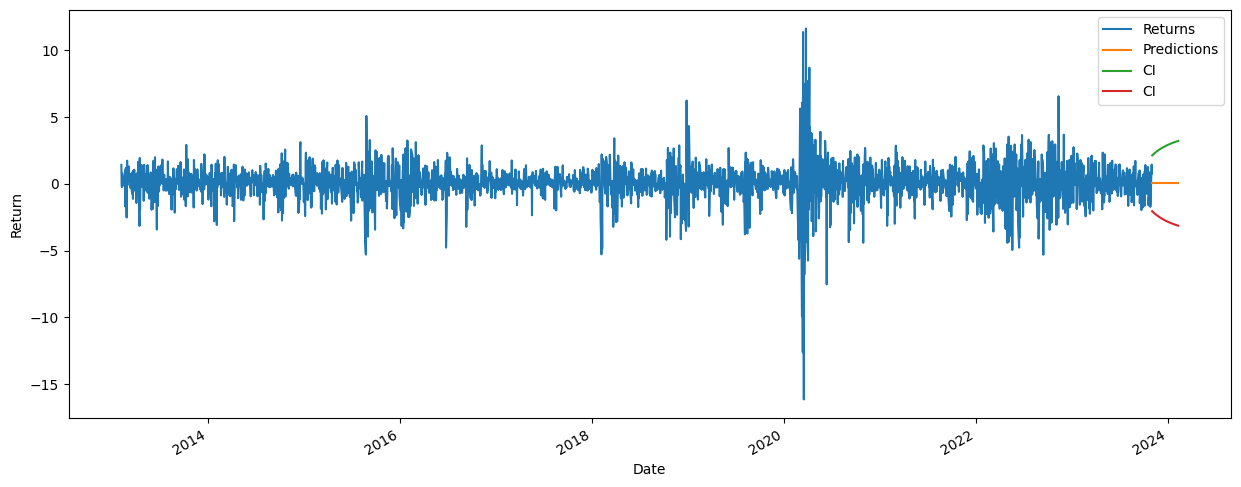

In [386]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = log_returns.tail(1).index
confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

## BoxCox

In [387]:
min_return = returns.min()
shifted_returns = returns - min_return + 1

transformed_returns, lambda_value = boxcox(shifted_returns)
transformed_returns = pd.Series(transformed_returns, index=returns.index)

transformed_returns = transformed_returns -np.mean(transformed_returns)

train_size = 0.8
train_data, test_data = train_test_split(transformed_returns, train_size=train_size, shuffle=False)

In [388]:
model_ar = AutoReg(train_data,lags=2)
residuals = model_ar.fit().resid

model_final = arch_model(residuals,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -37488.3
Distribution:                  Normal   AIC:                           74984.6
Method:            Maximum Likelihood   BIC:                           75013.7
                                        No. Observations:                10814
Date:                Tue, Jan 16 2024   Df Residuals:                    10813
Time:                        22:54:35   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0904  6.847e-02      1.320      0.187 [-4.37

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


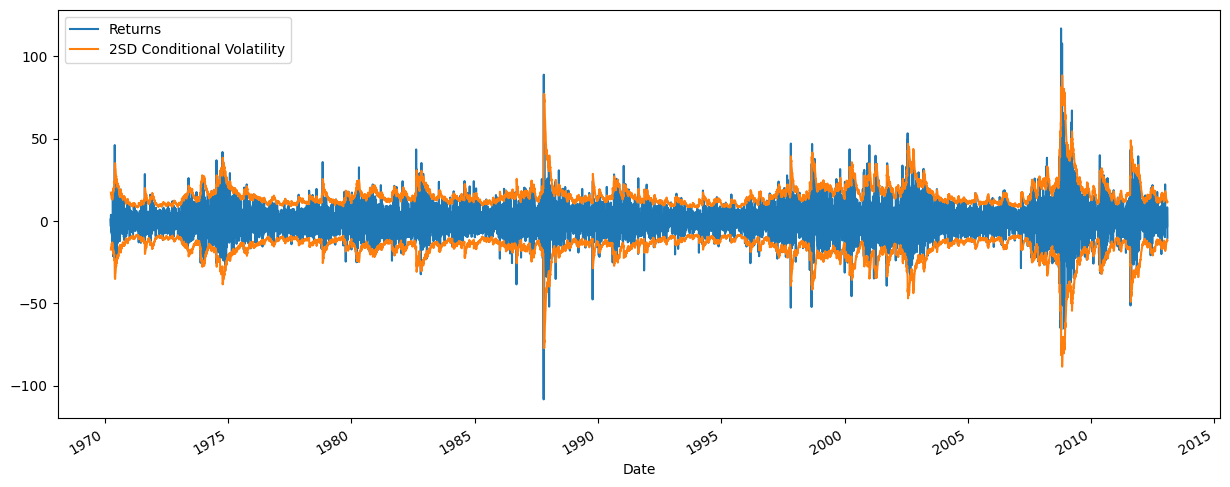

In [389]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

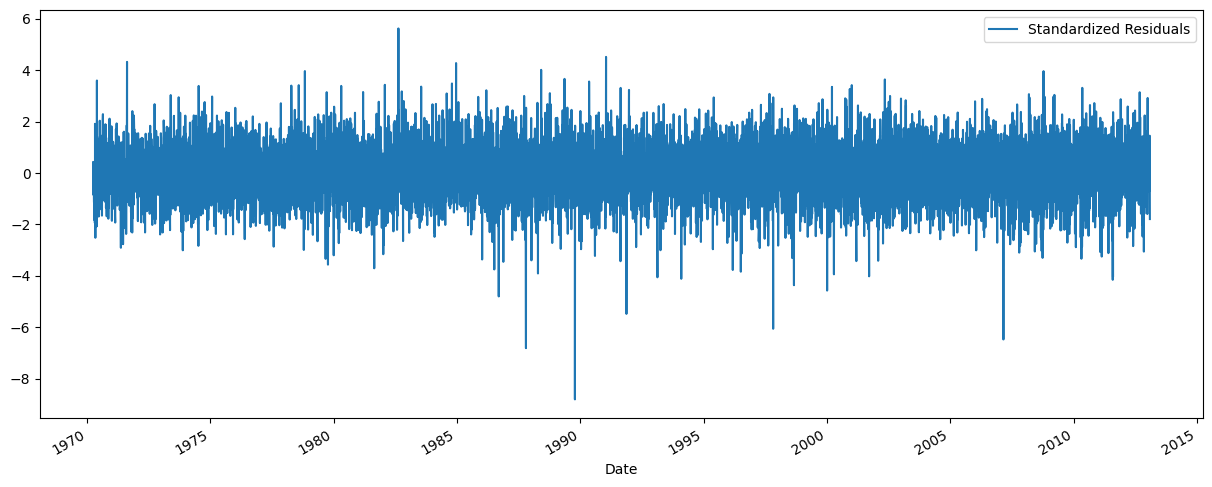

In [390]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

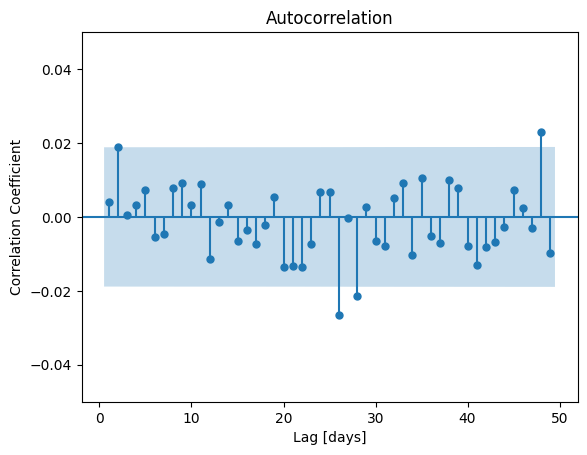

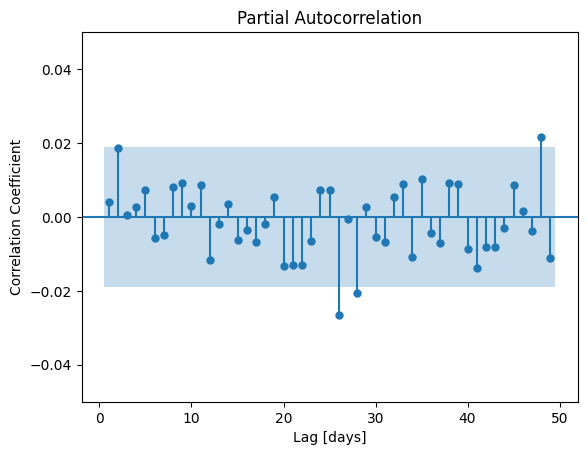

In [391]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

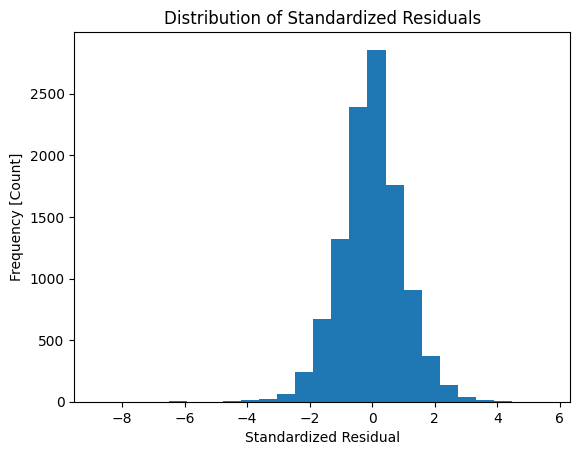

In [392]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

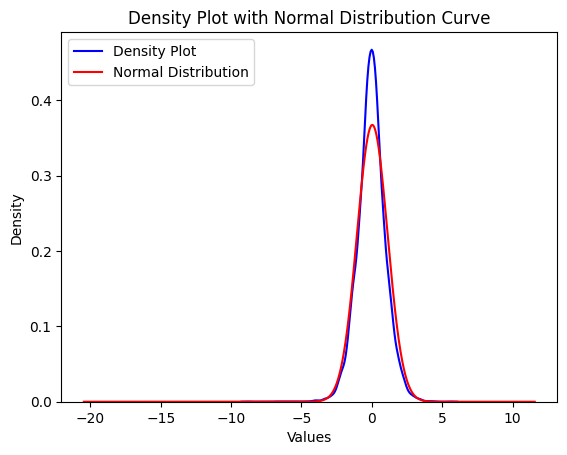

In [393]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

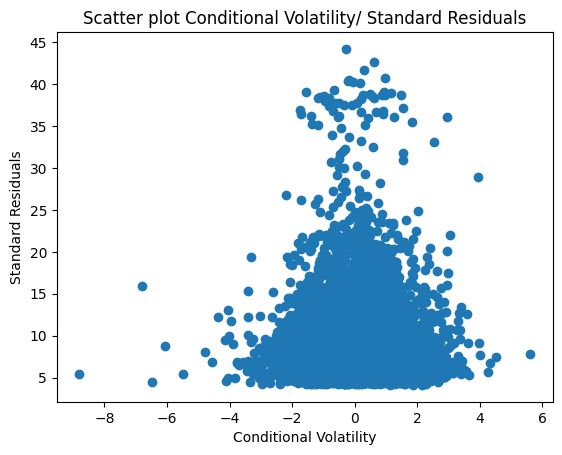

In [394]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

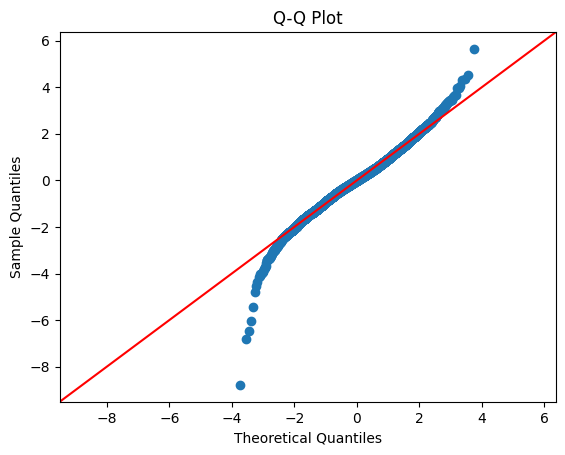

In [395]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

In [396]:
predictions = []

test_size = int(len(transformed_returns) *0.2)

for i in range(test_size):
    train_data_loop = transformed_returns.iloc[:-(test_size-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5

    predictions.append(next_pred)


c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

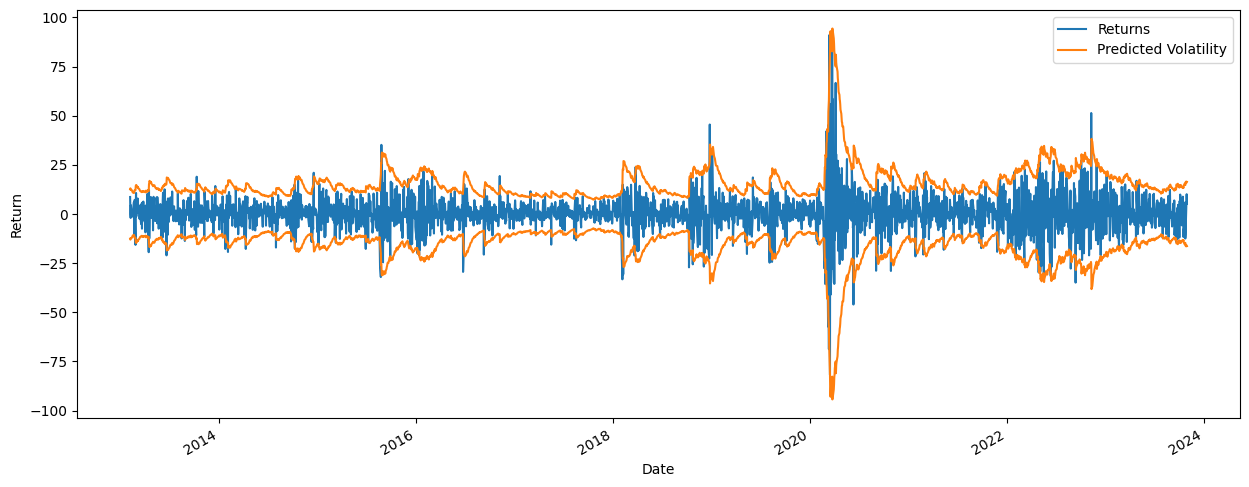

In [397]:
data_test_wfv = pd.Series(predictions, index=transformed_returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
transformed_returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [398]:
num_bootstrap_samples = 100

num_values = 10
table=[['observed','high_boot','low_boot','high_gaus','low_gaus']]

lower_boot = []
upper_boot = []

for i in range(num_values):
    train_data_loop = transformed_returns.iloc[:-(num_values-i)]

    model_ar = AutoReg(train_data_loop,lags=2)
    residuals = model_ar.fit().resid

    model = arch_model(residuals,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    residuals = results_arch.std_resid

    boot_sample = []

    for j in range(num_bootstrap_samples):
        sample = np.random.choice(residuals,size=len(residuals),replace=True)
        bootstrap_series = results_arch.conditional_volatility + sample
        
        model_boot = arch_model(bootstrap_series,vol='GARCH',p=1,q=1)
        results_boot = model_boot.fit(disp='off')

        forecast = results_boot.forecast(horizon=1,reindex=False)
        boot_pred = forecast.variance.iloc[0,0] ** 0.5

        boot_sample.append(boot_pred)    
    
    lower_boot.append(np.percentile(boot_sample,2.5,axis=0))
    upper_boot.append(np.percentile(boot_sample,97.5,axis=0))

for i in range(num_values):
    table.append([transformed_returns.iloc[len(transformed_returns)-num_values+i-1],2 * upper_boot[i],-2 * lower_boot[i],2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1],-2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1]])

print(tabulate(table, tablefmt="fancy_grid"))

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provide

╒═════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ observed            │ high_boot          │ low_boot            │ high_gaus          │ low_gaus            │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.546165692348751  │ 3.5374672931042106 │ -2.0963885350187828 │ 13.722486990515849 │ -13.722486990515849 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -11.715053696497947 │ 3.6548450301174706 │ -2.07070300859646   │ 13.209771075216343 │ -13.209771075216343 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -7.644861655173116  │ 3.7043309607497212 │ -2.1268858748009505 │ 14.384567615627354 │ -14.384567615627354 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -11.0455

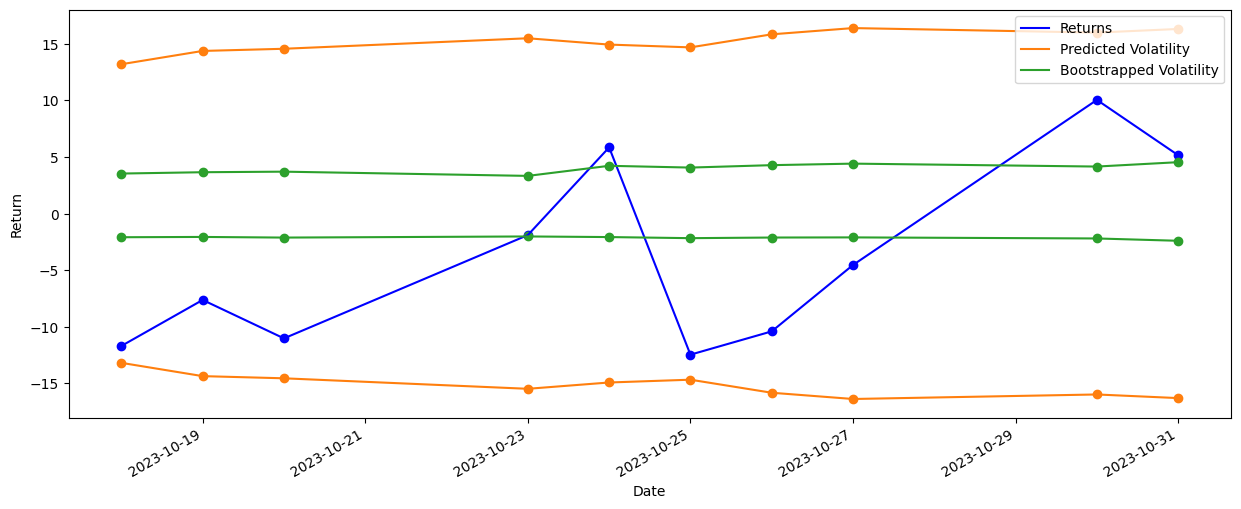

In [399]:
plt.subplots(figsize=(15, 6))
plt.scatter(x= transformed_returns.tail(num_values).index,y=transformed_returns.tail(num_values),color='blue')
plt.plot(transformed_returns.tail(num_values),label="Returns",color='blue')

(2 * data_test_wfv.tail(num_values)).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv.tail(num_values)).plot(c="C1")
plt.scatter(transformed_returns.tail(num_values).index,2 * data_test_wfv.tail(num_values),c="C1")
plt.scatter(transformed_returns.tail(num_values).index,-2 * data_test_wfv.tail(num_values),c="C1")

upper_boot = pd.Series(upper_boot, data_test_wfv.tail(num_values).index)
lower_boot = pd.Series(lower_boot, data_test_wfv.tail(num_values).index)

plt.plot(2 * upper_boot,c="C2", label="Bootstrapped Volatility")
plt.plot(-2 * lower_boot,c="C2")
plt.scatter(transformed_returns.tail(num_values).index,2 * upper_boot,c="C2")
plt.scatter(transformed_returns.tail(num_values).index,-2 *lower_boot,c="C2")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

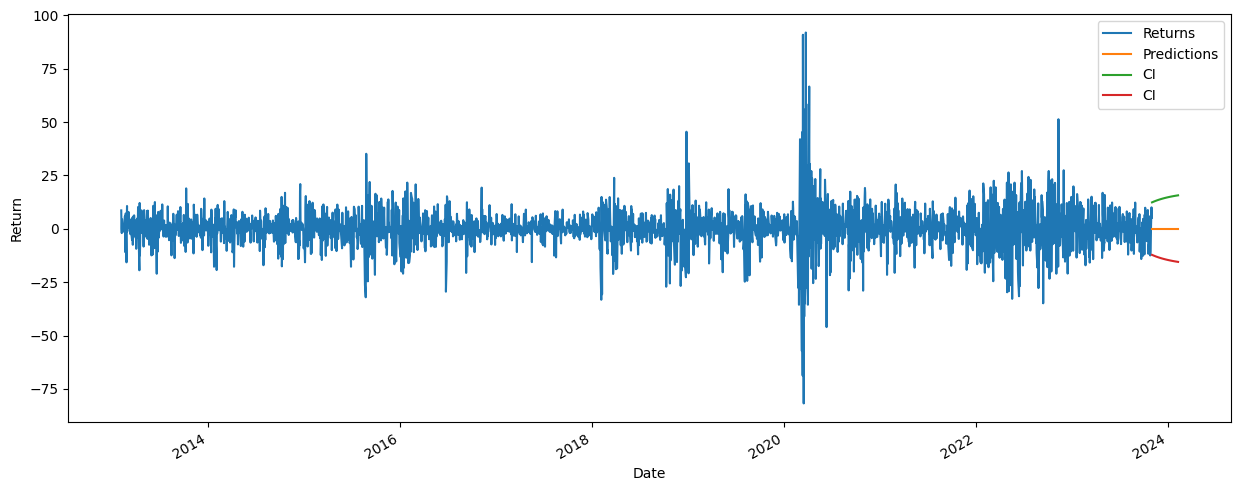

In [400]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = transformed_returns.tail(1).index
confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()